In [1]:
suppressPackageStartupMessages(library(MASS))
suppressPackageStartupMessages(library(nlme))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(repr))
suppressPackageStartupMessages(library(mgcv))
suppressPackageStartupMessages(library(ggrepel))

In [9]:
data_dir = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/environmental_raw_data"
mcc_file = "/Volumes/KeithSSD/ChesapeakeMicrobiome/data/otu_tables/microbial_community_clusters.txt"

env_data_file = paste(data_dir, "merged_paired_water_quality_data.txt", sep="/")
habitat_file = paste(data_dir, "Transformed_WQ_Vars_and_Habitats.txt", sep="/")

habitat_srs <- read.delim(habitat_file, row.names=1)
badhabits <- names(habitat_srs) %in% names(habitat_srs)[grep('HABITAT', colnames(habitat_srs))]
habitat_srs <- habitat_srs[!badhabits]
mcc_srs <- read.delim(mcc_file, row.names=1)[rownames(habitat_srs), c('Microbial.Clusters', 'Habitat')]
envdata_pre <- read.delim(env_data_file, row.names=1)
addl_cols = c('Station', "qPCR.ct", "WaterColumnPosition", "LinearTime", 'FallPeak', "DayLength",
              "cruise_id", 'SampleDate', 'Discharge_Sum.15' , 'Discharge_Susquehanna.15')
addl_cols = c(grep('WIND_RATIO_BWI', colnames(envdata_pre)),
               grep('PRECIP24HR_BWI', colnames(envdata_pre)),
               grep('measurement_PAR', colnames(envdata_pre)),
               which(colnames(envdata_pre) %in% addl_cols))


envdata <- cbind.data.frame(habitat_srs, envdata_pre[rownames(habitat_srs), addl_cols], mcc_srs)
keepers = colnames(envdata)[which(!(1:ncol(envdata) %in% grep('instant', colnames(envdata))))]
envdata = envdata[,keepers]
envdata[which(envdata$qPCR.ct %in% c("", 'TBD')), 'qPCR.ct'] = NA
envdata[,'Habitat'] <- factor(envdata[,'Habitat'])
envdata[,'Station'] <- factor(envdata[,'Station'])
envdata[,'WaterColumnPosition'] <- factor(envdata[,'WaterColumnPosition'])
envdata[,'Microbial.Clusters'] <- factor(envdata[,'Microbial.Clusters'])
envdata[,'cruise_id'] <- factor(envdata[,'cruise_id'])
colSums(is.na(envdata))

PHEO                       TN                       TP 
                       0                        0                        0 
                    CHLA                      DOP                      DON 
                       0                        0                        0 
                    NH4F                     NO2F                     NO3F 
                       0                        0                        0 
                      PC                     PO4F                       DO 
                       0                        0                        0 
                      PH                 SALINITY                    WTEMP 
                       0                        0                        0 
                Latitude        WIND_RATIO_BWI.15        WIND_RATIO_BWI.30 
                       0                        0                        0 
       WIND_RATIO_BWI.60        PRECIP24HR_BWI.15        PRECIP24HR_BWI.30 
                       0                        0                        0 
       PRECIP24HR_BWI.60       measurement_PAR.15       measurement_PAR.30 
                       0                        0                        0 
      measurement_PAR.60                  Station                  qPCR.ct 
                       0                        0                      156 
     WaterColumnPosition                cruise_id               SampleDate 
                       0                        0                        0 
              LinearTime                DayLength                 FallPeak 
                       0                        0                        0 
Discharge_Susquehanna.15         Discharge_Sum.15       Microbial.Clusters 
                       0                        0                        0 
                 Habitat 
                       0

In [10]:
station_groups = list('1' = c('CB2.2', 'CB3.1'),
                      '2' = c('CB3.2', 'CB3.3C', 'CB4.1C', 'CB4.2C'),
                      '3' = c('CB4.3C', 'CB4.4'),
                      '4' = c('CB5.1', 'CB5.2'),
                      '5' = c('CB5.4', 'CB5.3', 'CB7.1'),
                      '6' = c('CB6.2', 'CB6.1', 'CB6.3', 'CB6.4'),
                      '7' = c('CB7.2', 'CB7.3', 'CB7.4'))

envdata[,'StatName'] <- NA
for (stg in names(station_groups)){
    envdata[which(envdata[,'Station'] %in% station_groups[[stg]]), 'StatName'] <- stg
}

envdata$StatName <- factor(envdata$StatName)
print(sum(is.na(envdata[,'StatName'])))
table(envdata$StatName)


[1] 0



 1  2  3  4  5  6  7 
26 39 28 12 52 50 29 

In [11]:
library(phyloseq)
library(picante)
#OTU table rarefied only
otu_table_dir = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/otu_tables'
otu_table_file = paste(otu_table_dir, "final_rare_no_abund_filt.2.txt", sep="/")
OTU = read.delim(otu_table_file, row.names=1)
OTU.clean1 = OTU[rownames(envdata), ]
OTU.clean = as.matrix(OTU.clean1[,colSums(OTU.clean1) > 0])

sample(rowSums(OTU.clean), 10)
sample(colSums(OTU.clean), 10)

# OTU table rarefied abundance threshold
otu_table_file2 = paste(otu_table_dir, "final_rarefied_table.2.txt", sep="/")
OTU.rar.thresh = read.delim(otu_table_file2, row.names=1)
OTU.clean.rar.thresh = OTU.rar.thresh[rownames(envdata), ]
OTU.clean.rar.thresh = as.matrix(OTU.rar.thresh[,colSums(OTU.rar.thresh) > 0])

sample(rowSums(OTU.clean.rar.thresh), 10)
sample(colSums(OTU.clean.rar.thresh), 10)

# OTU Table raw
otu_table_file3 = paste(otu_table_dir, "final_unrarefied_table.2.txt", sep="/")
OTU.clean.raw = read.delim(otu_table_file3, row.names=1)
OTU.clean.raw = OTU.clean.raw[rownames(envdata), ]
OTU.clean.raw = as.matrix(OTU.clean.raw[,colSums(OTU.clean.raw) > 0])

sample(rowSums(OTU.clean.raw), 10)
sample(colSums(OTU.clean.raw), 10)

Loading required package: ape

Loading required package: vegan

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



SB050817TAWCSCB71D20BR2TR1I349  SB081216TAWCSCB32D10BR1TR2I621 
                           3125                            3125 
  SB080717TAWCSCB62D9BR1TR1I448 SB081216TAWCSCB42CD26BR2TR1I612 
                           3125                            3125 
  SB071116TAWCSCB62D9BR1TR1I161 SB041117TAWCSCB42CD26BR1TR1I293 
                           3125                            3125 
  SB071116TAWCSCB62D9BR2TR1I162  SB081216TAWCSCB71D20BR2TR1I201 
                           3125                            3125 
 SB082817TAWCSCB73D12BR1TR1I478 SB081216TAWCSCB42CD26BR1TR1I183 
                           3125                            3125

OTU17547  OTU8177  OTU2069  OTU7163   OTU107 OTU11684  OTU2438 OTU29338 
       1        2       27        2     1173        2        1        1 
 OTU4665    OTU15 
      13     6972

SB081216TAWCSCB53D25BR2TR1I189  SB082817TAWCSCB51D33BR1TR1I466 
                           2997                            2997 
 SB060517TAWCSCB73D12BR1TR1I376 SB081216TAWCSCB33CD24BR1TR1I181 
                           2997                            2997 
 SB060517TAWCSCB63D10BR1TR1I372  SB082817TAWCSCB44D31BR1TR1I465 
                           2997                            2997 
 SB060517TAWCSCB53D25BR2TR1I367   SB060517TAWCSCB62D9BR1TR1I371 
                           2997                            2997 
SB081216TAWCSCB33CD24BR1TR2I623  SB041117TAWCSCB31D13BR1TR1I289 
                           2997                            2997

OTU748 OTU1325 OTU1444  OTU565  OTU733 OTU1237 OTU1638  OTU353 OTU1396  OTU119 
    239      37      74     139     134      91      81     199      92    1559

SB050817TAWCSCB51D33BR1TR1I330 SB080717TAWCSCB42CD26BR1TR1I429 
                         274471                          465398 
 SB060517TAWCSCB44D31BR1TR1I363 SB080717TAWCSCB33CD24BR1TR1I427 
                         103473                          126171 
  SB041117TAWCSCB62D9BR1TR1I312 SB081216TAWCSCB42CD26BR2TR1I612 
                         136759                          123778 
 SB082817TAWCSCB51D33BR1TR1I466  SB082916TAWCSCB53D25BR1TR1I225 
                          92274                          116487 
 SB082916TAWCSCB64D10BR1TR1I236  SB050817TAWCSCB54D25BR1TR1I343 
                         375977                          147413

OTU29670 OTU14837 OTU48351 OTU28739 OTU51867 OTU50114 OTU52467  OTU8961 
      12       43        3       12        3        3        2       37 
OTU23196 OTU39408 
      19        6

In [19]:
#Taxonomy of each OTU
taxa_file = paste(otu_table_dir, "taxa_table_with_OTUs.txt", sep="/")
tax = read.delim(taxa_file, row.names=1)
tax_mat = as.matrix(tax)
colnames(tax_mat)[1] <- 'Domain'
tax_mat[tax_mat == ""] <- NA

tax.table.clean.raw  = tax_mat[colnames(OTU.clean.raw), ]
OTU.table.clean.raw = otu_table(OTU.clean.raw, taxa_are_rows = FALSE)
TAX.table.clean.raw = tax_table(tax.table.clean.raw)
physeq.clean.raw = phyloseq(OTU.table.clean.raw, TAX.table.clean.raw)
physeq.clean.raw

tax.table.clean.rar.t  = tax_mat[colnames(OTU.clean.rar.thresh), ]
OTU.table.clean.rar.t = otu_table(OTU.clean.rar.thresh, taxa_are_rows = FALSE)
TAX.table.clean.rar.t = tax_table(tax.table.clean.rar.t)
physeq.clean.rar.t = phyloseq(OTU.table.clean.rar.t, TAX.table.clean.rar.t)
physeq.clean.rar.t

tax.table.clean  = tax_mat[colnames(OTU.clean), ]
OTU.table.clean = otu_table(OTU.clean, taxa_are_rows = FALSE)
TAX.table.clean = tax_table(tax.table.clean)
physeq.clean = phyloseq(OTU.table.clean, TAX.table.clean)
physeq.clean

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 27746 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 27746 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1416 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 1416 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11450 taxa and 236 samples ]
tax_table()   Taxonomy Table:    [ 11450 taxa by 7 taxonomic ranks ]

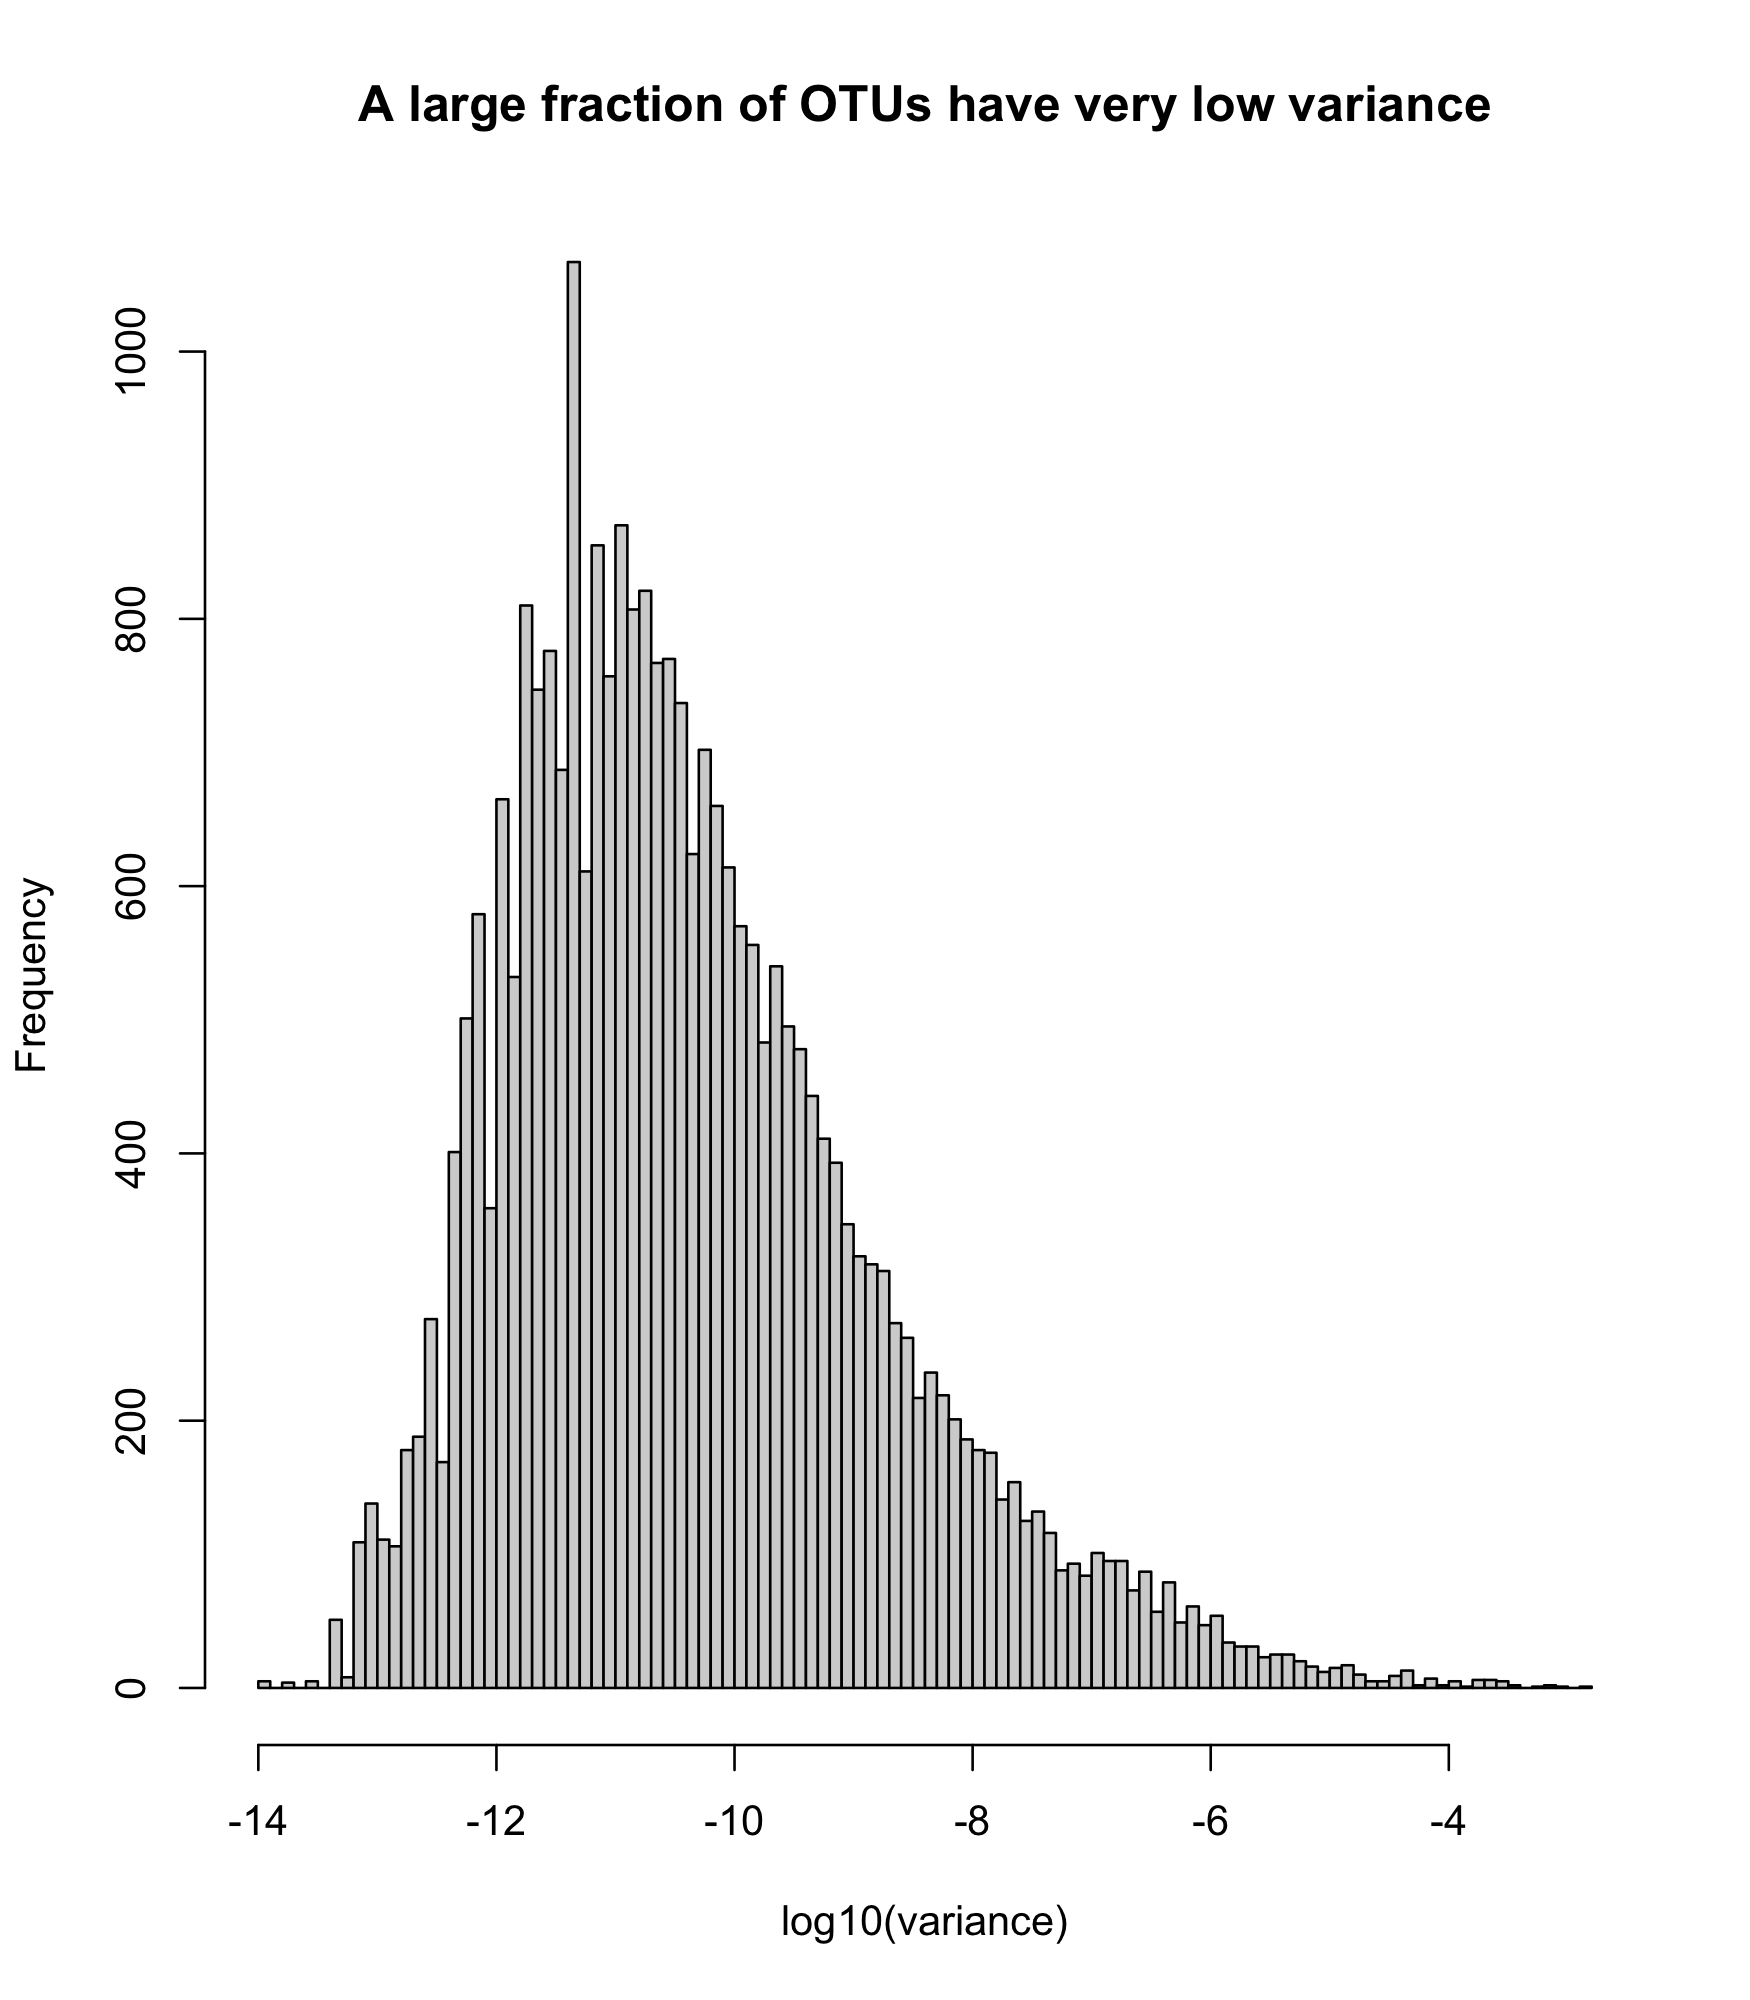

In [39]:
options(repr.plot.width=7, repr.plot.height=3, repr.plot.res=250)
physeq.clean.raw.ra = transform_sample_counts(physeq.clean.raw, function(x){x/sum(x)})
logvar = log10(apply(otu_table(physeq.clean.raw.ra), 2, var))
hist(logvar, xlab="log10(variance)", breaks=100, main="A large fraction of OTUs have very low variance")

diff_Thresholds_raw = list()
diff_Thresholds = list()
counter=0
for (varianceThreshold in 10^(-1*seq(5, 12, 0.25))){
    keepOTUs = names(which(apply(otu_table(physeq.clean.raw.ra), 2, var) > varianceThreshold))
    physeq.clean.vt = prune_taxa(keepOTUs, physeq.clean.raw.ra)
    physeq.clean.vt.raw = prune_taxa(keepOTUs, physeq.clean.raw)
    counter=counter + 1
    diff_Thresholds[[counter]] = physeq.clean.vt
    diff_Thresholds_raw[[counter]] = physeq.clean.vt.raw
    flush.console()
}

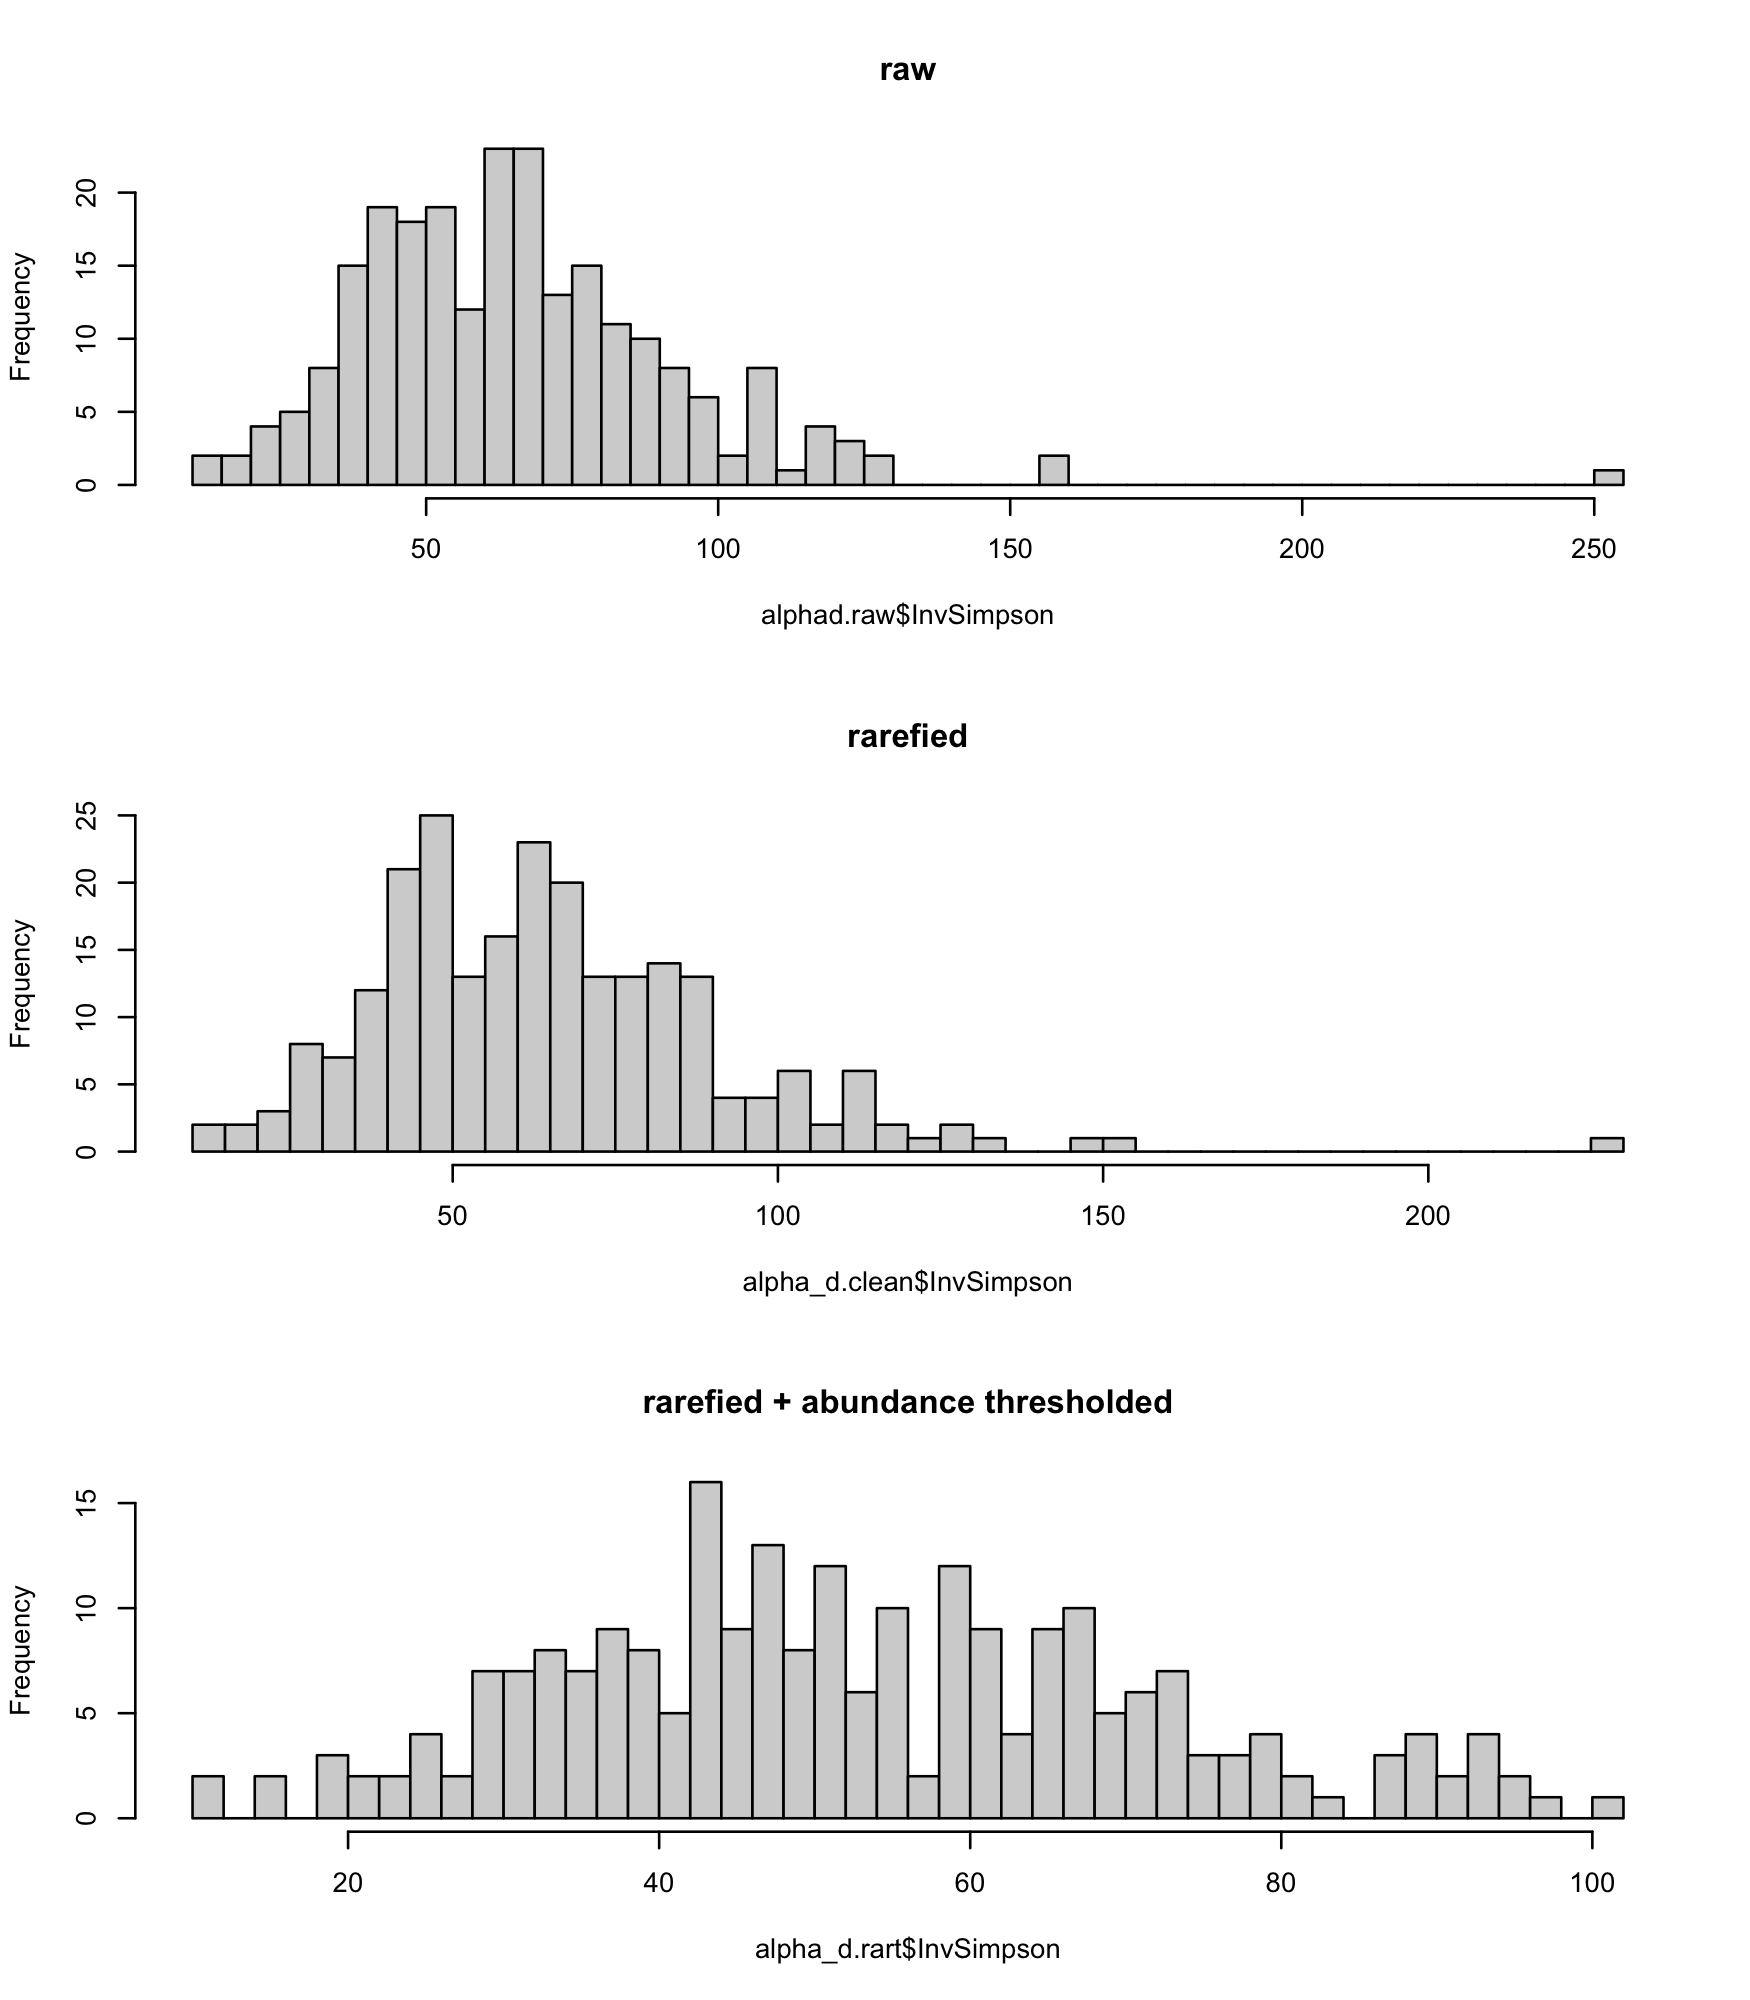

In [21]:
alphad.raw = estimate_richness(physeq.clean.raw, split = TRUE, measures = c('InvSimpson'))
alpha_d.rart = estimate_richness(physeq.clean.rar.t, split = TRUE, measures = c('InvSimpson'))
alpha_d.clean = estimate_richness(physeq.clean, split = TRUE, measures = c('InvSimpson'))
options(repr.plot.width=7, repr.plot.height=8, repr.plot.res=250)
par(mfrow=c(3,1))
hist(alphad.raw$InvSimpson, breaks=50, main='raw')
hist(alpha_d.clean$InvSimpson, breaks=50, main='rarefied')
hist(alpha_d.rart$InvSimpson, breaks=50, main='rarefied + abundance thresholded')

In [45]:
library(nortest)
threshs_used = 10^(-1*seq(5, 12, 0.25))
ra_table = otu_table(physeq.clean.raw.ra)
for (t_ in 1:length(diff_Thresholds)){
    physeq.clean.vt = diff_Thresholds[[t_]]
    kept_babies = otu_table(physeq.clean.vt)
    physeq.clean.vt.raw = diff_Thresholds_raw[[t_]]
    physeq.clean.vt.raw.ra = suppressMessages(rarefy_even_depth(physeq.clean.vt.raw, rngseed=42))
    kept_babies_ra = otu_table(physeq.clean.vt.raw.ra)
    minabund = min(apply(ra_table[,colnames(kept_babies)], 2, max))
    alpha_d.x = suppressWarnings(estimate_richness(physeq.clean.vt.raw.ra, 
                                                   split = TRUE, measures = c('InvSimpson', 'Observed')))
    x = cbind(alpha_d.x[,'Observed'], rowSums(otu_table(diff_Thresholds_raw[[t_]])))
    print(paste(t_, threshs_used[t_], round(minabund*100, 3), round(cor(x)[2,1], 3), ncol(kept_babies), ncol(kept_babies_ra), sep=" | "))
    print(paste(round(quantile(alpha_d.x$InvSimpson, c(0.01, 0.25, 0.5, 0.75, .99))), collapse=", "))
    print(ad.test(alpha_d.x$InvSimpson)$p.value)
    flush.console()
}

[1] "1 | 1e-05 | 1.364 | 0.145 | 115 | 115"
[1] "5, 16, 22, 26, 34"
[1] 0.325353
[1] "2 | 5.62341325190349e-06 | 1.08 | 0.176 | 152 | 152"
[1] "6, 20, 25, 30, 39"
[1] 0.1891962
[1] "3 | 3.16227766016838e-06 | 0.758 | 0.183 | 213 | 213"
[1] "8, 23, 29, 35, 45"
[1] 0.3764773
[1] "4 | 1.77827941003892e-06 | 0.59 | 0.172 | 285 | 285"
[1] "9, 25, 33, 40, 52"
[1] 0.2467132
[1] "5 | 1e-06 | 0.459 | 0.199 | 386 | 386"
[1] "10, 29, 36, 46, 63"
[1] 0.1841676
[1] "6 | 5.62341325190349e-07 | 0.359 | 0.199 | 522 | 522"
[1] "11, 31, 40, 51, 71"
[1] 0.2544959
[1] "7 | 3.16227766016838e-07 | 0.281 | 0.253 | 679 | 679"
[1] "12, 34, 44, 57, 79"
[1] 0.1927274
[1] "8 | 1.77827941003892e-07 | 0.188 | 0.249 | 884 | 884"
[1] "13, 36, 47, 60, 84"
[1] 0.1611745
[1] "9 | 1e-07 | 0.158 | 0.272 | 1130 | 1130"
[1] "14, 39, 50, 65, 91"
[1] 0.1116406
[1] "10 | 5.62341325190349e-08 | 0.121 | 0.3 | 1349 | 1349"
[1] "14, 40, 52, 66, 97"
[1] 0.2014112
[1] "11 | 3.16227766016838e-08 | 0.088 | 0.316 | 1643 | 1643"
[1] "15

In [362]:
seq(5, 12, 0.25)[10]

[1] 7.25

In [ ]:
tree_dir = '/Volumes/KeithSSD/ChesapeakeMicrobiome/data/phylogenetic_tree'

tree_file = paste(tree_dir, "RAxML_rootedTree.root.query_all_abund.2.ref.tre", sep="/")
tree_obj.f = read_tree(tree_file, errorIfNULL=T)
TREE.clean = prune_taxa(taxa=colnames(OTU.clean), tree_obj.f)
physeq.phylo = phyloseq(OTU.table.clean, TAX.table.clean, envdata, TREE.clean)
physeq.phylo
FaithsPD.phylo = pd(OTU.clean, TREE.clean, include.root=TRUE)
colnames(FaithsPD.phylo) <- c('FaithsPD', 'Observed.ASVs')


tree_file2 = paste(tree_dir, "RAxML_rootedTree.root.query_high_abund.2.ref.tre", sep="/")
tree_obj.s = read_tree(tree_file2, errorIfNULL=T)
TREE.clean.rt1 = prune_taxa(taxa=colnames(OTU.clean.rar.thresh), tree_obj.s)
physeq.rt1 = phyloseq(OTU.table.clean.rar.t, TAX.table.clean.rar.t, envdata, TREE.clean.rt1)
physeq.rt1
TREE.clean.rt2 = prune_taxa(taxa=colnames(OTU.clean.rar.thresh), tree_obj.f)
physeq.rt2 = phyloseq(OTU.table.clean.rar.t, TAX.table.clean.rar.t, envdata, TREE.clean.rt2)
physeq.rt2

FaithsPD.rt1 = pd(OTU.clean.rar.thresh, TREE.clean.rt1, include.root=TRUE)
colnames(FaithsPD.rt1) <- c('FaithsPD', 'Observed.ASVs')

FaithsPD.rt2 = pd(OTU.clean.rar.thresh, TREE.clean.rt2, include.root=TRUE)
colnames(FaithsPD.rt2) <- c('FaithsPD', 'Observed.ASVs')



	Anderson-Darling normality test

data:  FaithsPD.phylo$FaithsPD
A = 5.4112, p-value = 2.189e-13



	Anderson-Darling normality test

data:  FaithsPD.rt1$FaithsPD
A = 1.1281, p-value = 0.005837



	Anderson-Darling normality test

data:  FaithsPD.rt2$FaithsPD
A = 1.3016, p-value = 0.002178



	Anderson-Darling normality test

data:  FaithsPD.best$FaithsPD
A = 1.2263, p-value = 0.00334


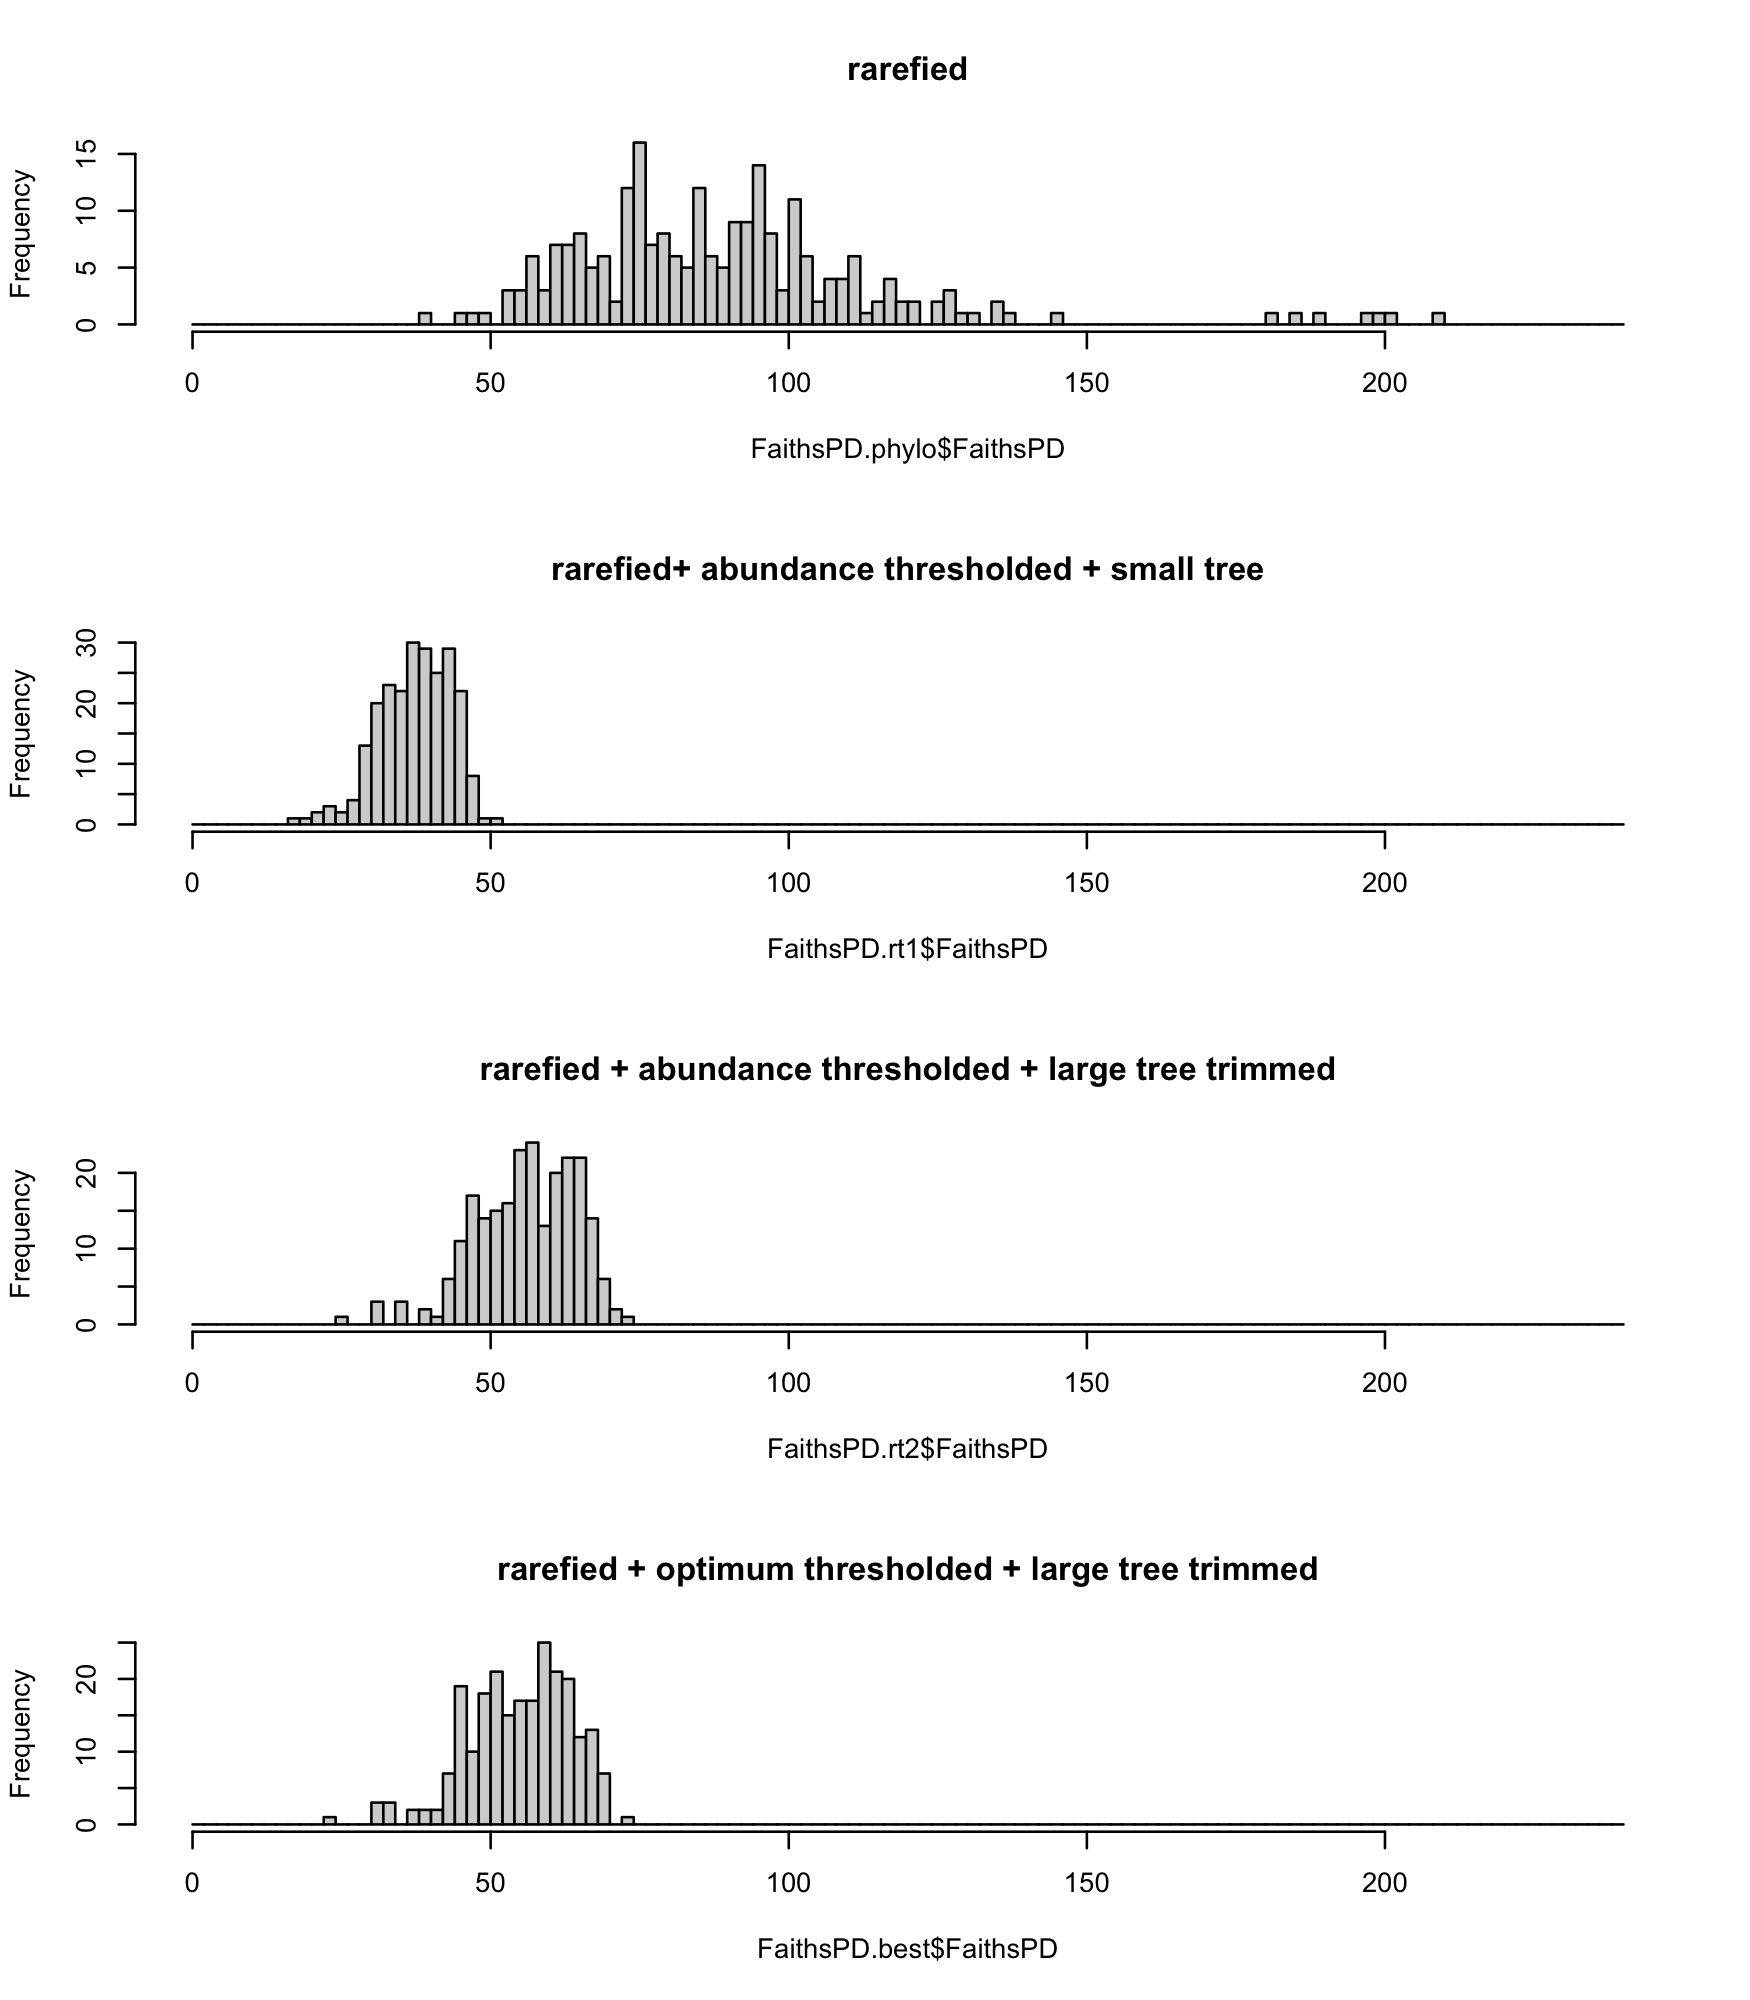

In [95]:
OTU.best = suppressMessages(rarefy_even_depth(otu_table(diff_Thresholds_raw[[10]]), rngseed=42))
TAX.best = tax_table(diff_Thresholds_raw[[10]])[colnames(OTU.best),]
TREE.best = prune_taxa(taxa=colnames(OTU.best), tree_obj.f)
FaithsPD.best = pd(OTU.best, TREE.clean.rt2, include.root=TRUE)
colnames(FaithsPD.best) <- c('FaithsPD', 'Observed.ASVs')


options(repr.plot.width=7, repr.plot.height=8, repr.plot.res=250)
par(mfrow=c(4,1))
hist(FaithsPD.phylo$FaithsPD, breaks=seq(0, 240, 2), main='rarefied')
hist(FaithsPD.rt1$FaithsPD, breaks=seq(0, 240, 2), main='rarefied+ abundance thresholded + small tree')
hist(FaithsPD.rt2$FaithsPD, breaks=seq(0, 240, 2), main='rarefied + abundance thresholded + large tree trimmed')
hist(FaithsPD.best$FaithsPD, breaks=seq(0, 240, 2), main='rarefied + optimum thresholded + large tree trimmed')
ad.test(FaithsPD.phylo$FaithsPD)
ad.test(FaithsPD.rt1$FaithsPD)
ad.test(FaithsPD.rt2$FaithsPD)
ad.test(FaithsPD.best$FaithsPD)

In [96]:
physeq2 <- phyloseq(OTU.best, TAX.best, envdata, TREE.best)
alpha_alt <- estimate_richness(physeq2, split = TRUE, measures = c('InvSimpson'))
alpha_alt = cbind.data.frame(alpha_alt, FaithsPD.best)
cor(alpha_alt)
all_alpha = cbind.data.frame(envdata, alpha_alt)
full_data_file = paste(data_dir, "Transformed_WQVars_Hab_and_aDiv.txt", sep="/")
write.table(all_alpha, file=full_data_file, sep="\t")
write.table(OTU.best, file='/Volumes/KeithSSD/ChesapeakeMicrobiome/data/otu_tables/final_rarefied_table.best.txt', sep="\t")

InvSimpson FaithsPD  Observed.ASVs
InvSimpson    1.0000000  0.5773692 0.5156605    
FaithsPD      0.5773692  1.0000000 0.8387560    
Observed.ASVs 0.5156605  0.8387560 1.0000000

In [97]:
droppers = c('Station', 'qPCR.ct', 'SampleDate', 'FaithsPD', 'InvSimpson', 'Observed.ASVs')
keepers_ = colnames(all_alpha)[which(!(colnames(all_alpha) %in% droppers))]
keepers_
predictors_ = all_alpha[, keepers_]
num_cols = names(predictors_)[sapply(predictors_, class) == 'numeric']
predictors_[,num_cols] = scale(predictors_[,num_cols])
response_1 = all_alpha[,'FaithsPD']
response_2 = all_alpha[,'InvSimpson']
dim(predictors_)
length(response_1)
length(response_2)

[1] "PHEO"                     "TN"                      
 [3] "TP"                       "CHLA"                    
 [5] "DOP"                      "DON"                     
 [7] "NH4F"                     "NO2F"                    
 [9] "NO3F"                     "PC"                      
[11] "PO4F"                     "DO"                      
[13] "PH"                       "SALINITY"                
[15] "WTEMP"                    "Latitude"                
[17] "WIND_RATIO_BWI.15"        "WIND_RATIO_BWI.30"       
[19] "WIND_RATIO_BWI.60"        "PRECIP24HR_BWI.15"       
[21] "PRECIP24HR_BWI.30"        "PRECIP24HR_BWI.60"       
[23] "measurement_PAR.15"       "measurement_PAR.30"      
[25] "measurement_PAR.60"       "WaterColumnPosition"     
[27] "cruise_id"                "LinearTime"              
[29] "DayLength"                "FallPeak"                
[31] "Discharge_Susquehanna.15" "Discharge_Sum.15"        
[33] "Microbial.Clusters"       "Habitat"                 
[35] "StatName"

[1] 236  35

[1] 236

[1] 236


Call:
 randomForest(x = x, y = y, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 11

          Mean of squared residuals: 21.58144
                    % Var explained: 71.22

[1] "Microbial.Clusters"       "SALINITY"                
 [3] "DO"                       "PO4F"                    
 [5] "cruise_id"                "PC"                      
 [7] "CHLA"                     "TN"                      
 [9] "PHEO"                     "NO2F"                    
[11] "Discharge_Sum.15"         "FallPeak"                
[13] "PH"                       "DON"                     
[15] "WTEMP"                    "Discharge_Susquehanna.15"
[17] "TP"                       "WIND_RATIO_BWI.15"       
[19] "NO3F"                     "StatName"                
[21] "NH4F"                     "measurement_PAR.60"      
[23] "LinearTime"               "DOP"                     
[25] "measurement_PAR.30"       "Latitude"                
[27] "DayLength"                "WIND_RATIO_BWI.30"       
[29] "PRECIP24HR_BWI.60"        "measurement_PAR.15"      
[31] "PRECIP24HR_BWI.15"        "WIND_RATIO_BWI.60"       
[33] "WaterColumnPosition"      "PRECIP24HR_BWI.30"       
[35] "Habitat"

[1] 35


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables  RMSE Rsquared   MAE RMSESD RsquaredSD  MAESD Selected
         1 6.533   0.4446 4.982 0.9448    0.10724 0.8916         
         2 5.821   0.5558 4.503 0.5698    0.08052 0.4974         
         3 5.473   0.6097 4.249 0.6720    0.08319 0.5271         
         4 5.225   0.6505 4.055 0.7152    0.09687 0.5768         
         5 5.037   0.6802 3.859 0.5357    0.06553 0.4521         
         6 5.015   0.6753 3.850 0.5472    0.06221 0.4747         
         7 4.893   0.6916 3.766 0.5769    0.06206 0.4859         
         8 4.844   0.6984 3.720 0.5531    0.06152 0.4633         
         9 4.812   0.7013 3.704 0.5644    0.06110 0.4620         
        10 4.830   0.6993 3.725 0.5796    0.06347 0.4652         
        11 4.814   0.7019 3.731 0.5968    0.06060 0.4961         
        12 4.825   0.7003 3.733 0.5755    0.06165 0.4883         


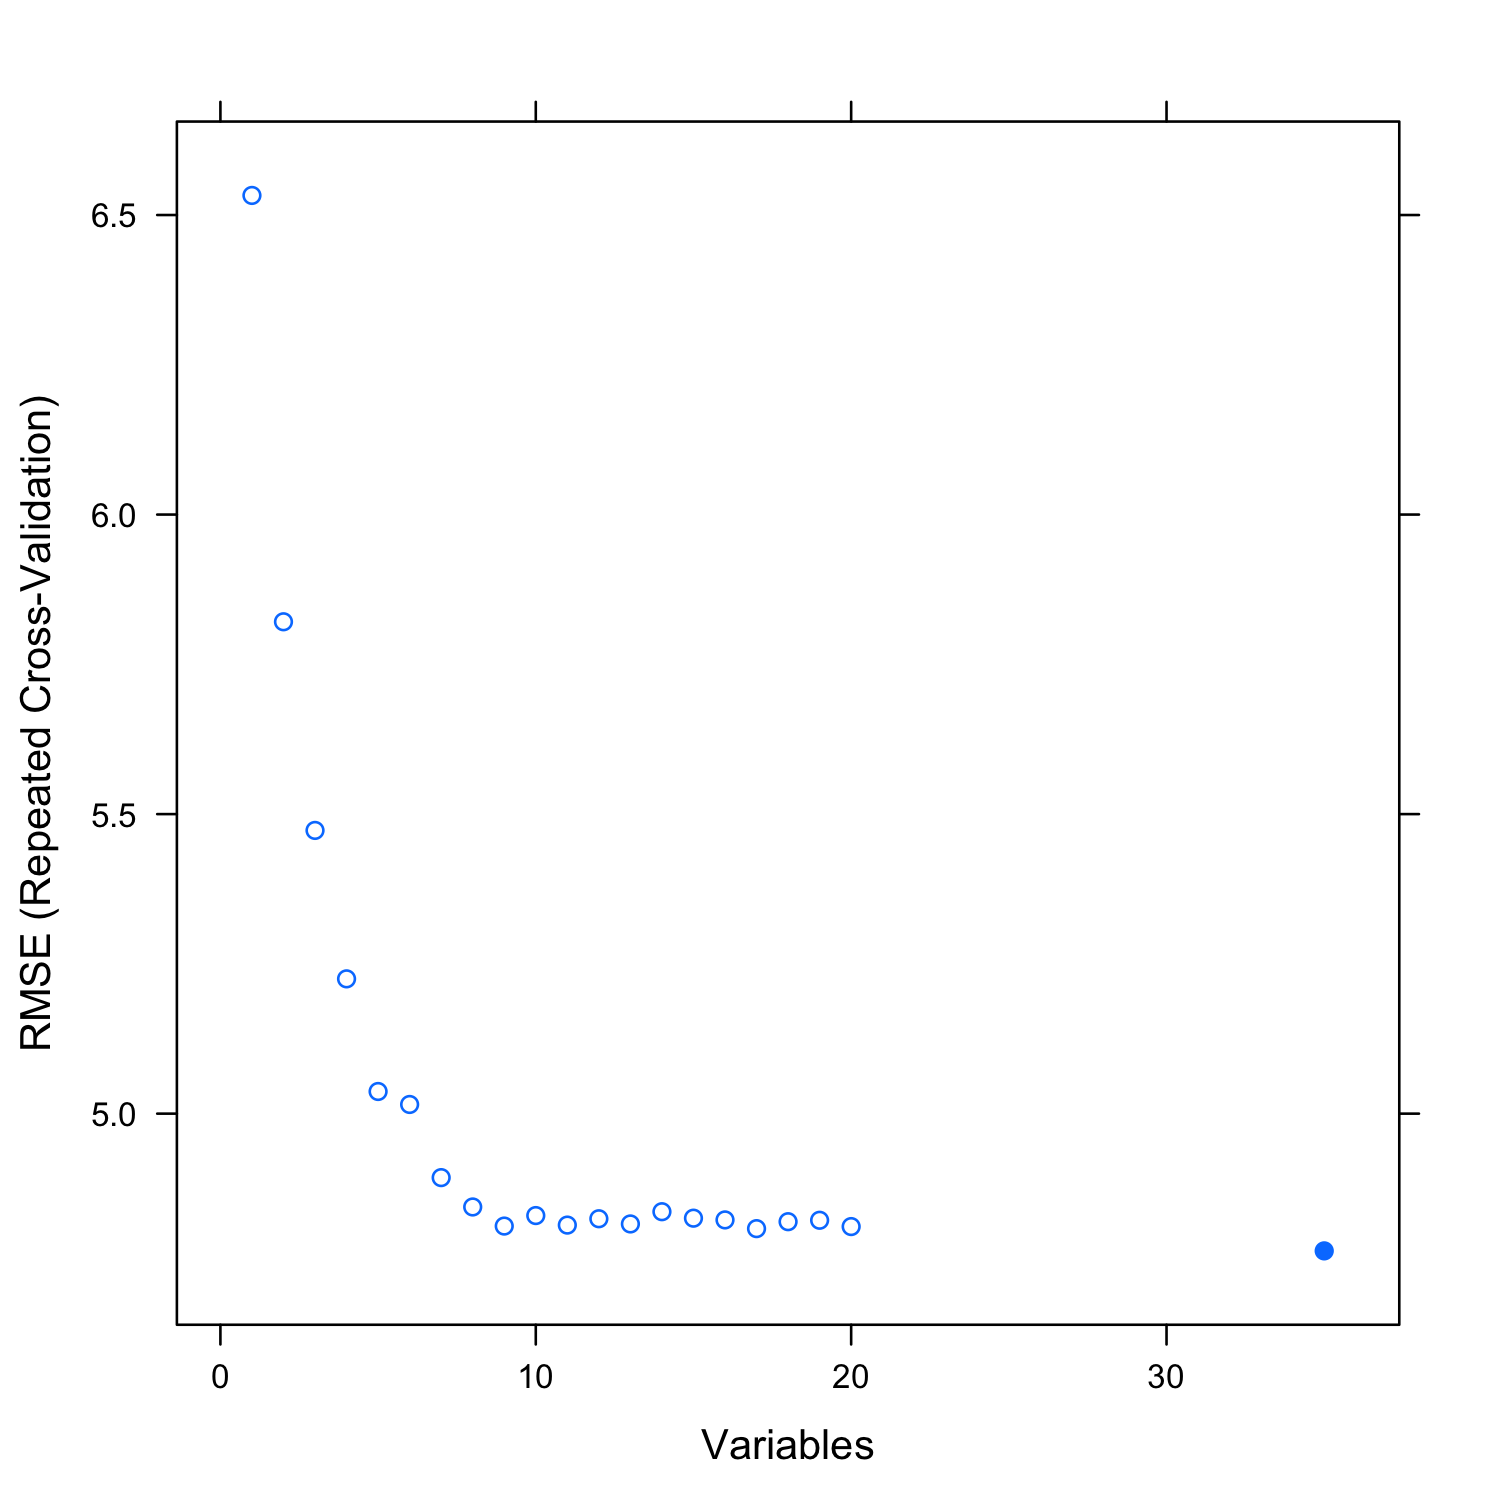

In [98]:
library(doParallel)
library(caret)

numCores <- 3
registerDoParallel(numCores)

ctrl <- rfeControl(functions = rfFuncs,
                   method = "repeatedcv",
                   repeats = 3,
                   number = 5,
                   verbose = T, 
                   allowParallel=T)

lmProfile.fpd <- rfe(x=predictors_, y=response_1,
                 sizes = 1:20,
                 rfeControl = ctrl)

lmProfile.fpd$fit
lmProfile.fpd$optVariables
lmProfile.fpd$bestSubset
lmProfile.fpd
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=250)
plot(lmProfile.fpd)
stopImplicitCluster()


Call:
 randomForest(x = x, y = y, importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 167.2338
                    % Var explained: 54.03

[1] "SALINITY"                 "cruise_id"               
 [3] "PO4F"                     "Habitat"                 
 [5] "CHLA"                     "WTEMP"                   
 [7] "NO2F"                     "TP"                      
 [9] "FallPeak"                 "Discharge_Sum.15"        
[11] "NO3F"                     "Discharge_Susquehanna.15"
[13] "PC"                       "DO"

[1] 14


Recursive feature selection

Outer resampling method: Cross-Validated (5 fold, repeated 3 times) 

Resampling performance over subset size:

 Variables  RMSE Rsquared   MAE RMSESD RsquaredSD  MAESD Selected
         1 16.54   0.3092 12.87  1.418    0.09200 1.2752         
         2 14.39   0.4409 11.25  1.235    0.11306 0.9191         
         3 14.02   0.4709 10.95  1.179    0.08786 0.8730         
         4 13.86   0.4815 10.90  1.278    0.10381 0.9066         
         5 13.77   0.4898 10.87  1.253    0.08853 0.9065         
         6 13.49   0.5070 10.64  1.458    0.10402 1.1272         
         7 13.44   0.5102 10.57  1.508    0.11120 1.1342         
         8 13.39   0.5143 10.52  1.508    0.11534 1.0851         
         9 13.38   0.5152 10.52  1.549    0.11547 1.2000         
        10 13.35   0.5174 10.55  1.685    0.12587 1.2765         
        11 13.36   0.5175 10.53  1.653    0.12654 1.2617         
        12 13.26   0.5250 10.47  1.607    0.12425 1.2362         


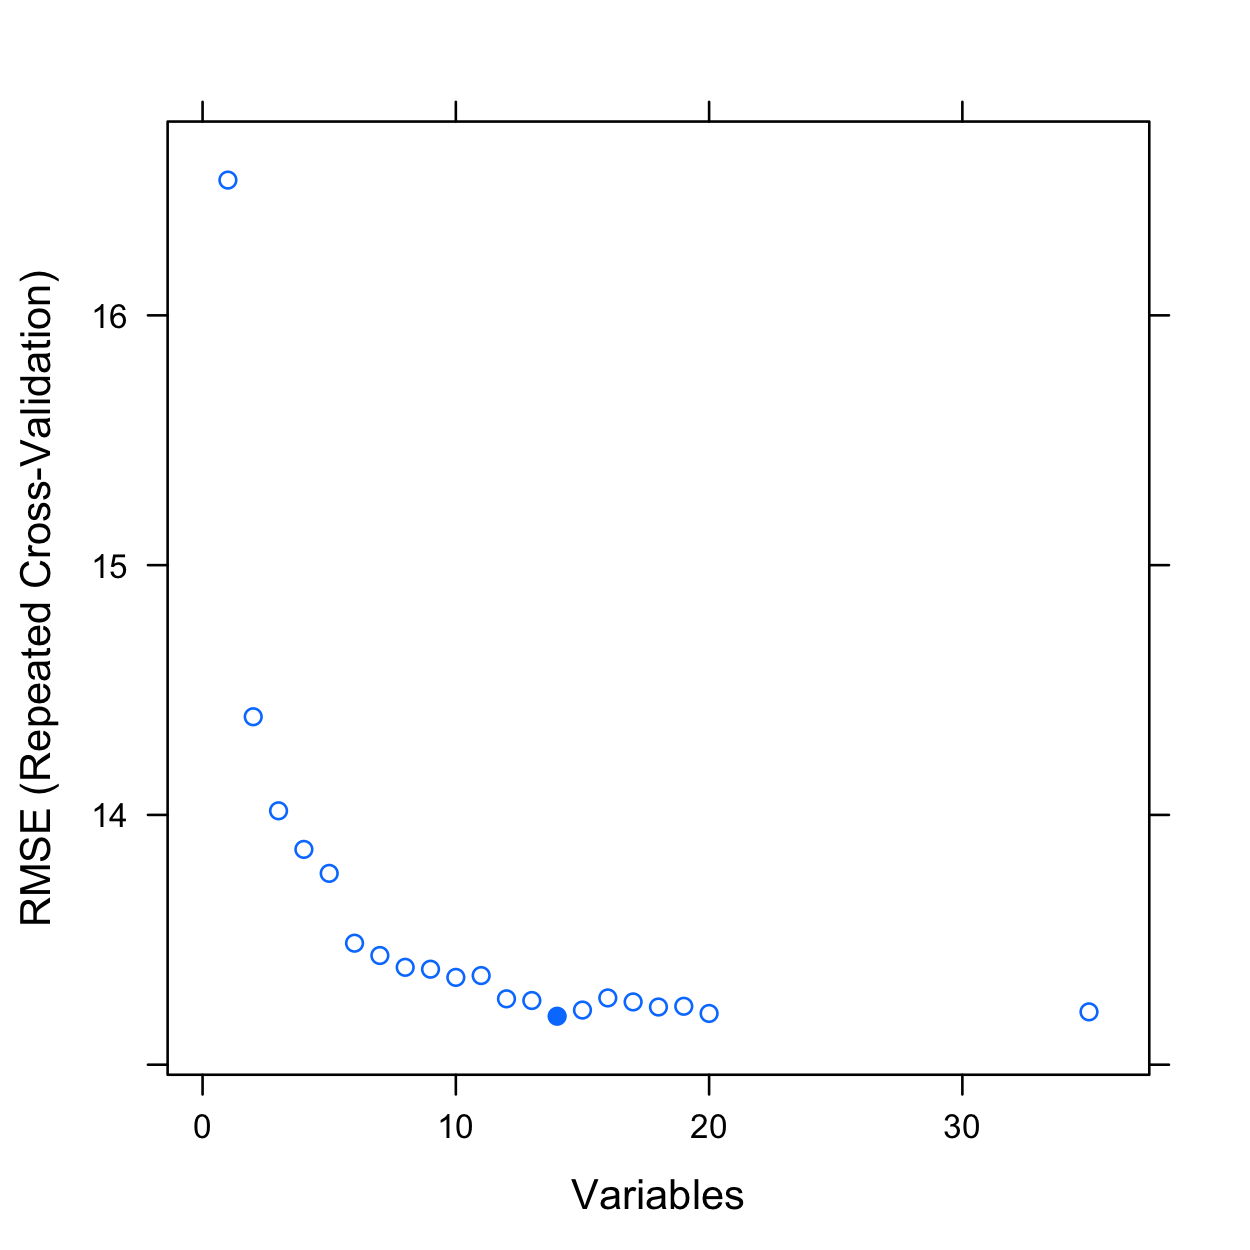

In [100]:
registerDoParallel(numCores)

ctrl <- rfeControl(functions = rfFuncs,
                   method = "repeatedcv",
                   repeats = 3,
                   number = 5,
                   verbose = T, 
                   allowParallel=T)

lmProfile.isi <- rfe(x=predictors_, y=response_2,
                 sizes = 1:20,
                 rfeControl = ctrl)

lmProfile.isi$fit
lmProfile.isi$optVariables
lmProfile.isi$bestSubset

lmProfile.isi
options(repr.plot.width=5, repr.plot.height=5, repr.plot.res=250)
plot(lmProfile.isi)
stopImplicitCluster()


In [274]:
library(nortest)
ad.test(response_1)
ad.test(response_2)
xform_const = powerTransform(lm(response_1~1))$lambda
response_1.1 = ((response_1^xform_const) - 1)/xform_const
ad.test(response_1.1)
print(xform_const)

xform_const2 = powerTransform(lm(response_2~1))$lambda
response_2.1 = ((response_2^xform_const2) - 1)/xform_const2
ad.test(response_2.1)
print(xform_const2)
pred_resp_f = cbind.data.frame(predictors_, response_1.1)
colnames(pred_resp_f) <- c(colnames(predictors_), 'FaithsPD')
pred_resp_f <- pred_resp_f[complete.cases(pred_resp_f),]
colSums(is.na(pred_resp_f))
pred_resp_i = cbind.data.frame(predictors_, response_2)
colnames(pred_resp_i) <- c(colnames(predictors_), 'InvSimpson')
pred_resp_i <- pred_resp_i[complete.cases(pred_resp_i),]
colSums(is.na(pred_resp_i))

dim(pred_resp_i)
dim(pred_resp_f)


	Anderson-Darling normality test

data:  response_1
A = 1.2263, p-value = 0.00334



	Anderson-Darling normality test

data:  response_2
A = 0.50466, p-value = 0.2014



	Anderson-Darling normality test

data:  response_1.1
A = 0.70425, p-value = 0.06519


     Y1 
2.17428 



	Anderson-Darling normality test

data:  response_2.1
A = 0.17499, p-value = 0.9239


       Y1 
0.7020438 


PHEO                       TN                       TP 
                       0                        0                        0 
                    CHLA                      DOP                      DON 
                       0                        0                        0 
                    NH4F                     NO2F                     NO3F 
                       0                        0                        0 
                      PC                     PO4F                       DO 
                       0                        0                        0 
                      PH                 SALINITY                    WTEMP 
                       0                        0                        0 
                Latitude        WIND_RATIO_BWI.15        WIND_RATIO_BWI.30 
                       0                        0                        0 
       WIND_RATIO_BWI.60        PRECIP24HR_BWI.15        PRECIP24HR_BWI.30 
                       0                        0                        0 
       PRECIP24HR_BWI.60       measurement_PAR.15       measurement_PAR.30 
                       0                        0                        0 
      measurement_PAR.60      WaterColumnPosition                cruise_id 
                       0                        0                        0 
              LinearTime                DayLength                 FallPeak 
                       0                        0                        0 
Discharge_Susquehanna.15         Discharge_Sum.15       Microbial.Clusters 
                       0                        0                        0 
                 Habitat                 StatName                 FaithsPD 
                       0                        0                        0

PHEO                       TN                       TP 
                       0                        0                        0 
                    CHLA                      DOP                      DON 
                       0                        0                        0 
                    NH4F                     NO2F                     NO3F 
                       0                        0                        0 
                      PC                     PO4F                       DO 
                       0                        0                        0 
                      PH                 SALINITY                    WTEMP 
                       0                        0                        0 
                Latitude        WIND_RATIO_BWI.15        WIND_RATIO_BWI.30 
                       0                        0                        0 
       WIND_RATIO_BWI.60        PRECIP24HR_BWI.15        PRECIP24HR_BWI.30 
                       0                        0                        0 
       PRECIP24HR_BWI.60       measurement_PAR.15       measurement_PAR.30 
                       0                        0                        0 
      measurement_PAR.60      WaterColumnPosition                cruise_id 
                       0                        0                        0 
              LinearTime                DayLength                 FallPeak 
                       0                        0                        0 
Discharge_Susquehanna.15         Discharge_Sum.15       Microbial.Clusters 
                       0                        0                        0 
                 Habitat                 StatName               InvSimpson 
                       0                        0                        0

[1] 236  36

[1] 236  36

In [275]:
upper_model = lm(InvSimpson ~ ., data=pred_resp_i)
lower_model = lm(InvSimpson ~ 1, data=pred_resp_i)
n = length(resid(lower_model))

fbstep_invsimp = stepAIC(lower_model, scope=formula(upper_model), 
                         scale = 0, direction = 'both', trace=1, k=log(n))
length(colnames(fbstep_invsimp$model))
extractAIC(fbstep_invsimp)
colnames(fbstep_invsimp$model)


Start:  AIC=1397.03
InvSimpson ~ 1

                           Df Sum of Sq   RSS    AIC
+ Habitat                   2   24435.6 61410 1328.9
+ SALINITY                  1   19465.1 66380 1341.8
+ Discharge_Sum.15          1   11647.4 74198 1368.1
+ FallPeak                  1   11601.8 74243 1368.2
+ Discharge_Susquehanna.15  1   11215.5 74630 1369.5
+ Microbial.Clusters        2   11234.7 74611 1374.9
+ PO4F                      1    8419.1 77426 1378.1
+ WaterColumnPosition       1    8265.8 77579 1378.6
+ DON                       1    6547.0 79298 1383.8
+ Latitude                  1    6404.1 79441 1384.2
+ measurement_PAR.60        1    5689.1 80156 1386.3
+ PRECIP24HR_BWI.60         1    5582.1 80263 1386.6
+ CHLA                      1    4105.8 81739 1390.9
+ PC                        1    4104.1 81741 1390.9
+ cruise_id                10   19230.4 66615 1391.8
+ TN                        1    3744.0 82101 1392.0
+ WTEMP                     1    3605.6 82240 1392.4
+ DayLengt


Step:  AIC=1299.52
InvSimpson ~ Habitat + DayLength + Discharge_Susquehanna.15 + 
    WTEMP + SALINITY

                           Df Sum of Sq   RSS    AIC
+ TN                        1    2993.1 46432 1290.2
+ NO2F                      1    1985.9 47439 1295.3
+ TP                        1    1874.2 47551 1295.9
+ PHEO                      1    1261.8 48163 1298.9
<none>                                  49425 1299.5
+ PO4F                      1    1062.6 48362 1299.9
+ NO3F                      1     954.7 48470 1300.4
+ WaterColumnPosition       1     787.1 48638 1301.2
+ PC                        1     770.1 48655 1301.3
+ NH4F                      1     736.8 48688 1301.4
+ PRECIP24HR_BWI.30         1     530.1 48895 1302.4
+ WIND_RATIO_BWI.30         1     470.7 48954 1302.7
- SALINITY                  1    1908.3 51333 1303.0
+ DOP                       1     329.1 49096 1303.4
- WTEMP                     1    2061.4 51487 1303.7
+ FallPeak                  1     214.1 49211 1

[1] 7

[1]    8.000 1262.531

[1] "InvSimpson"               "Habitat"                 
[3] "DayLength"                "Discharge_Susquehanna.15"
[5] "WTEMP"                    "SALINITY"                
[7] "TN"

In [276]:
abs(cor(apply(pred_resp_i[,colnames(fbstep_invsimp$model)], 2, as.numeric))) > 0.65

Warning message in apply(pred_resp_i[, colnames(fbstep_invsimp$model)], 2, as.numeric):
“NAs introduced by coercion”


InvSimpson Habitat DayLength Discharge_Susquehanna.15
InvSimpson                TRUE        NA    FALSE     FALSE                   
Habitat                     NA      TRUE       NA        NA                   
DayLength                FALSE        NA     TRUE     FALSE                   
Discharge_Susquehanna.15 FALSE        NA    FALSE      TRUE                   
WTEMP                    FALSE        NA    FALSE      TRUE                   
SALINITY                 FALSE        NA    FALSE     FALSE                   
TN                       FALSE        NA    FALSE     FALSE                   
                         WTEMP SALINITY TN   
InvSimpson               FALSE FALSE    FALSE
Habitat                     NA    NA       NA
DayLength                FALSE FALSE    FALSE
Discharge_Susquehanna.15  TRUE FALSE    FALSE
WTEMP                     TRUE FALSE    FALSE
SALINITY                 FALSE  TRUE     TRUE
TN                       FALSE  TRUE     TRUE

In [277]:
eM1 <- lm(InvSimpson~PHEO + SALINITY + Discharge_Sum.15 + PRECIP24HR_BWI.30, data=pred_resp_i)
postResample(obs=pred_resp_i$InvSimpson, pred=predict(eM1))
eM2 <- lm(InvSimpson~SALINITY + Discharge_Sum.15 + Habitat, data=pred_resp_i)
postResample(obs=pred_resp_i$InvSimpson, pred=predict(eM2))
eM3 <- lm(InvSimpson~Habitat + Discharge_Sum.15 + DayLength, data=pred_resp_i)
postResample(obs=pred_resp_i$InvSimpson, pred=predict(eM3))
eM4 <- lm(InvSimpson~ WTEMP + Discharge_Sum.15 + DayLength + SALINITY, data=pred_resp_i)
postResample(obs=pred_resp_i$InvSimpson, pred=predict(eM4))
eM5 <- lm(InvSimpson~Habitat + Discharge_Sum.15 + DayLength+ PRECIP24HR_BWI.30, data=pred_resp_i)
postResample(obs=pred_resp_i$InvSimpson, pred=predict(eM5))
anova(eM1, eM2, eM3, eM4, eM5)
AIC(eM1, eM2, eM3, eM4, eM5)
summary(eM2)
drop1(eM2, test="F")
coef(eM2)

RMSE   Rsquared        MAE 
14.6980041  0.4061011 11.6365511

RMSE   Rsquared        MAE 
15.1645444  0.3677999 12.1028289

RMSE   Rsquared        MAE 
15.1494452  0.3690583 12.1862498

RMSE   Rsquared        MAE 
15.1985886  0.3649582 11.9536395

RMSE   Rsquared        MAE 
14.9424889  0.3861791 11.9956855

Res.Df RSS      Df Sum of Sq  F        Pr(>F)     
1 231    50983.39 NA         NA       NA          NA
2 231    54271.36  0 -3287.9714       NA          NA
3 231    54163.34  0   108.0213       NA          NA
4 231    54515.31  0  -351.9714       NA          NA
5 230    52693.60  1  1821.7120 7.951511 0.005223979

df AIC     
eM1 6  1950.339
eM2 6  1965.088
eM3 6  1964.618
eM4 6  1966.147
eM5 7  1960.126


Call:
lm(formula = InvSimpson ~ SALINITY + Discharge_Sum.15 + Habitat, 
    data = pred_resp_i)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.969 -10.417   0.396  10.406  46.160 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        50.862      1.686  30.173  < 2e-16 ***
SALINITY            5.034      1.266   3.976 9.38e-05 ***
Discharge_Sum.15   -4.408      1.139  -3.869 0.000142 ***
HabitatH.2         11.765      3.072   3.829 0.000166 ***
HabitatH.3         -1.823      2.568  -0.710 0.478537    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.33 on 231 degrees of freedom
Multiple R-squared:  0.3678,	Adjusted R-squared:  0.3569 
F-statistic:  33.6 on 4 and 231 DF,  p-value: < 2.2e-16


Df Sum of Sq RSS      AIC      F value   Pr(>F)      
<none>           NA       NA  54271.36 1293.349        NA           NA
SALINITY          1 3713.699  57985.06 1306.970 15.806944 0.0000938424
Discharge_Sum.15  1 3516.763  57788.13 1306.167 14.968710 0.0001422196
Habitat           2 4357.623  58628.99 1307.576  9.273867 0.0001336408

(Intercept)         SALINITY Discharge_Sum.15       HabitatH.2 
       50.861707         5.033758        -4.407674        11.765498 
      HabitatH.3 
       -1.822989

In [278]:
library(caret)
options(repr.plot.width=4, repr.plot.height=3)

vf3 <- varIdent(form= ~ StatName)
vf2 <- varIdent(form= ~ cruise_id)

print("linear unweighted model")
envM1 <- lm(InvSimpson ~ PO4F + Discharge_Sum.15 + SALINITY, data=pred_resp_i)
postResample(pred = predict(envM1), obs = pred_resp_i$InvSimpson)

print("linear weighted model")
evM5 <- gls(InvSimpson~ PO4F + Discharge_Sum.15 + SALINITY, data=pred_resp_i, weights=vf3)
postResample(pred = predict(evM5), obs = pred_resp_i$InvSimpson)

print("linear weighted model2")
envM3 <- gls(InvSimpson~ PO4F + Discharge_Sum.15 + SALINITY, data=pred_resp_i, weights=vf2)
postResample(pred = predict(envM3), obs = pred_resp_i$InvSimpson)

print("nonlinear unweighted model")
envM2 <- gam(InvSimpson ~ s(PO4F, bs = "cs")  + s(Discharge_Sum.15, bs = "cs") + s(SALINITY, bs = "cs"), data=pred_resp_i)
postResample(pred = predict(envM2), obs = pred_resp_i$InvSimpson)

print("nonlinear weighted model1")
envM4 <- gamm(InvSimpson ~ s(PO4F, bs = "cs")  + s(Discharge_Sum.15, bs = "cs") + s(SALINITY, bs = "cs"), weights=vf3, data=pred_resp_i)
postResample(pred = predict(envM4$gam), obs = pred_resp_i$InvSimpson)

print("nonlinear weighted model2")
envM5 <- gamm(InvSimpson ~ s(PO4F, bs = "cs")  + s(Discharge_Sum.15, bs = "cs") + s(SALINITY, bs = "cs"), weights=vf2, data=pred_resp_i)
postResample(pred = predict(envM5$gam), obs = pred_resp_i$InvSimpson)

#AIC(envM4$lme)
#plot(envM3$gam)
summary(envM2)

[1] "linear unweighted model"


RMSE   Rsquared        MAE 
15.6297370  0.3284179 12.2599191

[1] "linear weighted model"


RMSE   Rsquared        MAE 
15.6297370  0.3284179 12.2599191

[1] "linear weighted model2"


RMSE   Rsquared        MAE 
15.6297370  0.3284179 12.2599191

[1] "nonlinear unweighted model"


RMSE   Rsquared        MAE 
13.0648335  0.5313659 10.2915063

[1] "nonlinear weighted model1"


RMSE   Rsquared        MAE 
13.7643243  0.4802323 10.7894763

[1] "nonlinear weighted model2"


RMSE   Rsquared        MAE 
13.7643243  0.4802323 10.7894763


Family: gaussian 
Link function: identity 

Formula:
InvSimpson ~ s(PO4F, bs = "cs") + s(Discharge_Sum.15, bs = "cs") + 
    s(SALINITY, bs = "cs")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  53.4498     0.8825   60.57   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                      edf Ref.df      F  p-value    
s(PO4F)             2.673      9  1.689 0.000525 ***
s(Discharge_Sum.15) 6.198      9  2.699 0.000488 ***
s(SALINITY)         6.943      9 10.020 7.58e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.497   Deviance explained = 53.1%
GCV = 197.88  Scale est. = 183.78    n = 236

In [287]:
# cor(pred_resp_i[,c('measurement_PAR.60', 'WTEMP', 'Discharge_Sum.15', 'FallPeak')])
addedvars = c('InvSimpson', 'SALINITY', 'measurement_PAR.60', 'WTEMP', 'PO4F')
remaining_vars  = colnames(pred_resp_i)[which(!(colnames(pred_resp_i) %in% addedvars))]
factors_ = remaining_vars[which(sapply(pred_resp_i[,remaining_vars], class) == 'factor')]
string_start = "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6)"
x = formula(string_start)
fI2 <- gam(x, data =pred_resp_i)
score_start = BIC(fI2)
addone = c()
for (rv in remaining_vars){
    if (rv %in% factors_){
        mod_string = paste(string_start, ' + ', rv)
    } else {
        mod_string = paste(string_start, '+ s(', rv, ", bs='cs', k=6)")
    }
    fmod <- gam(formula(mod_string), data = pred_resp_i)
    print(mod_string)
    score_diff = score_start - BIC(fmod)
    addone = c(addone, score_diff)
}
names(addone) <- remaining_vars
base::sort(addone, decreasing=T)[1:5]


[1] "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( PHEO , bs='cs', k=6)"
[1] "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( TN , bs='cs', k=6)"
[1] "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( TP , bs='cs', k=6)"
[1] "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( CHLA , bs='cs', k=6)"
[1] "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( DOP , bs='cs', k=6)"
[1] "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( DON , bs='cs', k=6)"
[1] "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( NH4F , bs='cs', k=6)"
[1] "InvSimpson ~ 1 + s(SALINITY, bs='cs', k=6) + s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( NO2F , bs='c

WIND_RATIO_BWI.60          FallPeak        LinearTime WIND_RATIO_BWI.30 
     2.568710e+00      0.000000e+00     -1.160005e-06     -2.959263e-06 
              DOP 
    -3.430189e-06

[1] 233   6


Family: gaussian 
Link function: identity 

Formula:
InvSimpson ~ s(PO4F, bs = "cs", k = 6) + s(FallPeak, bs = "cs", 
    k = 5) + s(SALINITY, bs = "cs", k = 6)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  53.2918     0.9391   56.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df      F  p-value    
s(PO4F)     3.116      5  3.600 0.000323 ***
s(FallPeak) 3.100      4  2.853 0.008191 ** 
s(SALINITY) 4.103      5 12.786 9.21e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.441   Deviance explained = 46.6%
GCV = 215.96  Scale est. = 205.47    n = 233

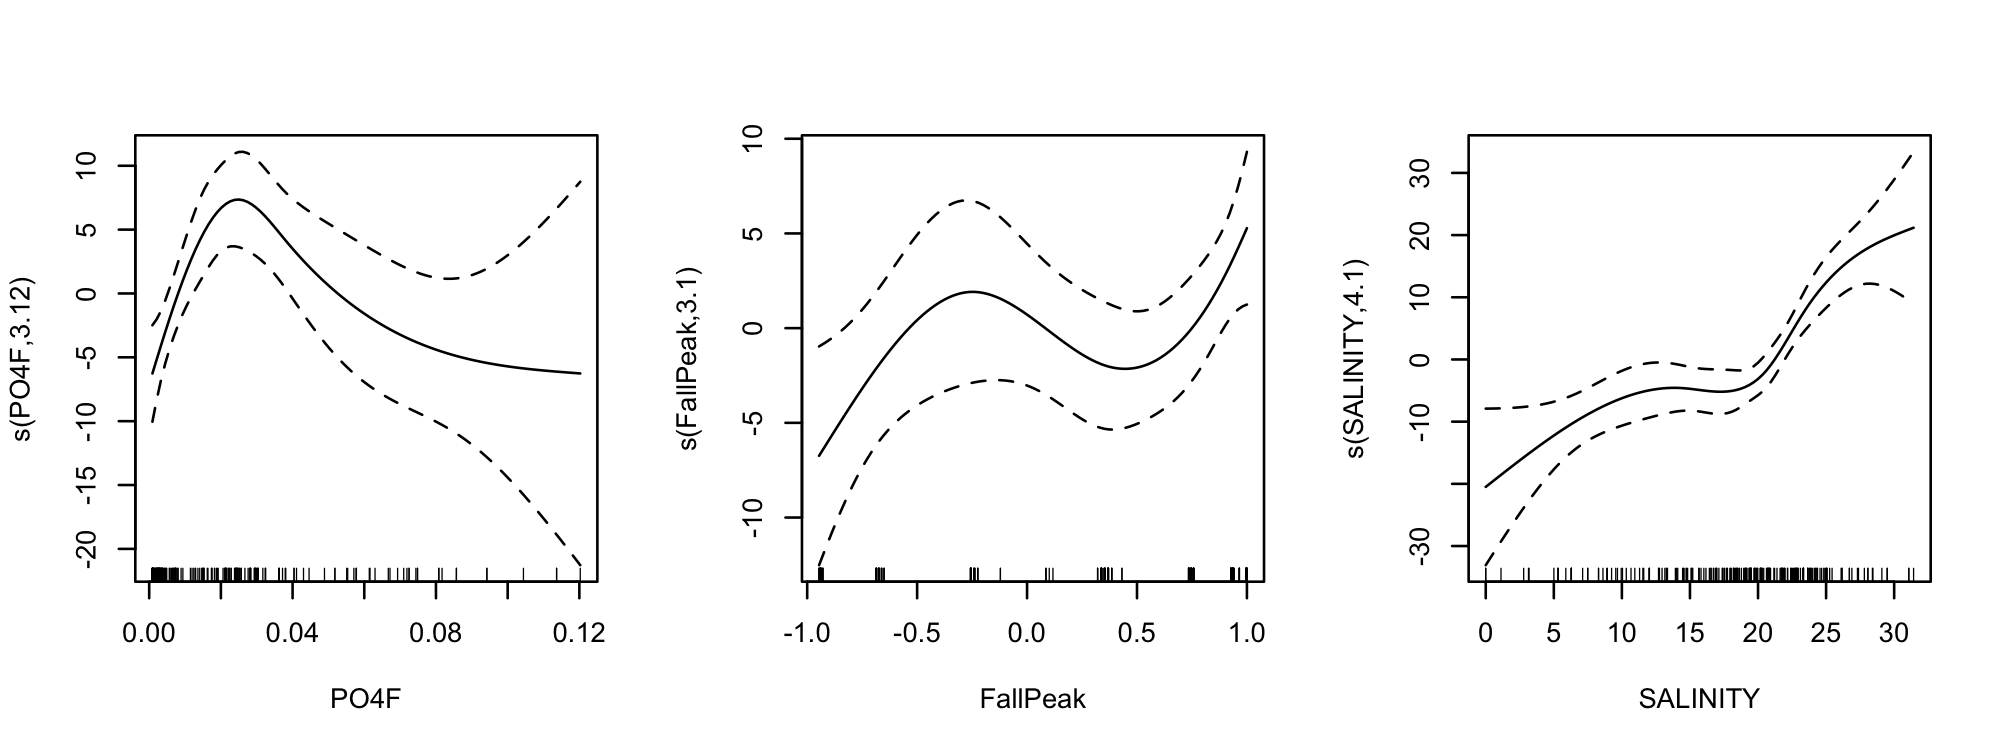

In [290]:
selected_predictors1 = c('PO4F', 'FallPeak', 'cruise_id', 'SALINITY')
selected_predictors2 = c('StatName')
selected_response = c('InvSimpson')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], response_2)
colnames(obs_df) = c(selected_predictors1, selected_predictors2, selected_response)
obs_df <- obs_df[complete.cases(obs_df),]
envM2 <- gam(InvSimpson ~ s(PO4F, bs = "cs", k=6)  + 
                          s(FallPeak, bs = "cs", k=5) + 
                          s(SALINITY, bs = "cs", k=6), data=obs_df)
              
dim(obs_df)
summary(envM2)
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res = 250)
par(mfrow=c(1,3))
plot.gam(envM2, scale=0)



	Anderson-Darling normality test

data:  resid(envM2)
A = 0.18604, p-value = 0.9049


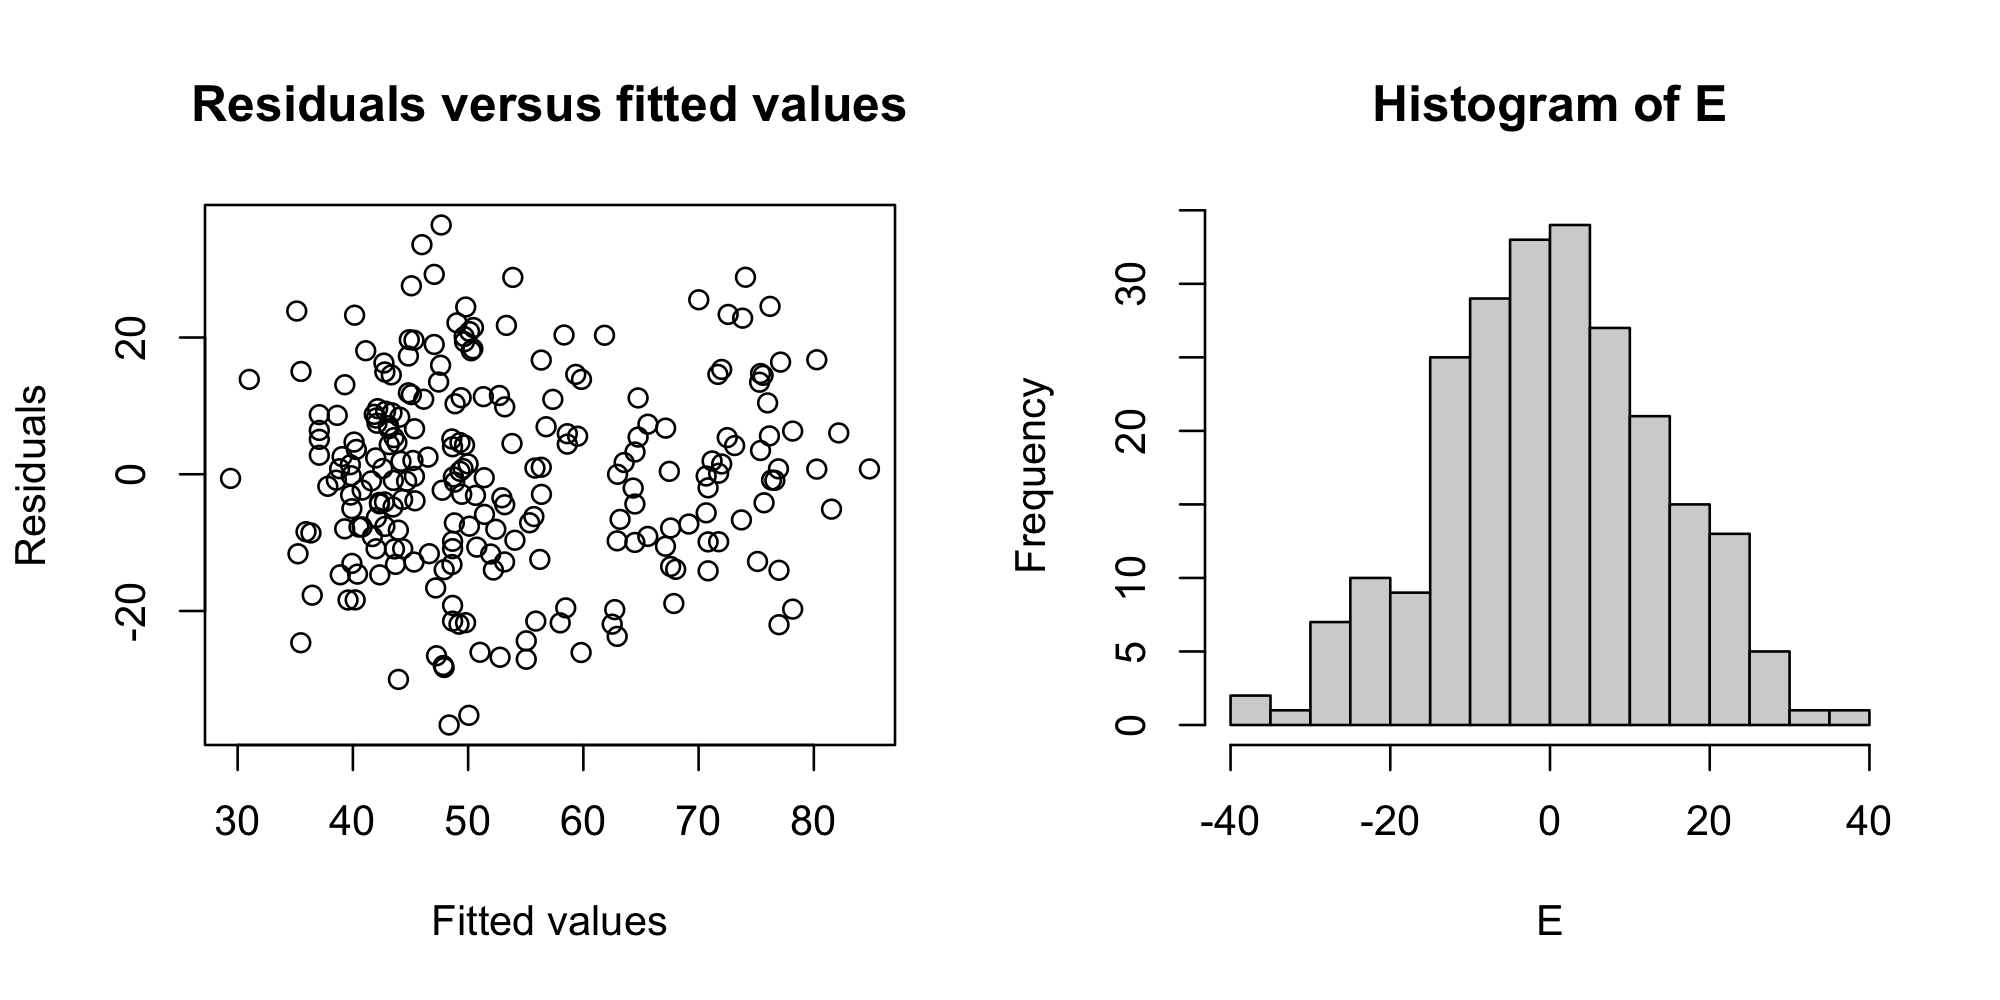

In [292]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 250)
ad.test(resid(envM2))

E <- resid(envM2)
Fit <- fitted(envM2)
op <- par(mfrow = c(1, 2))
plot(x = Fit,y = E, xlab = "Fitted values", ylab = "Residuals", main = "Residuals versus fitted values")
hist(E, nclass = 15)
par(op)

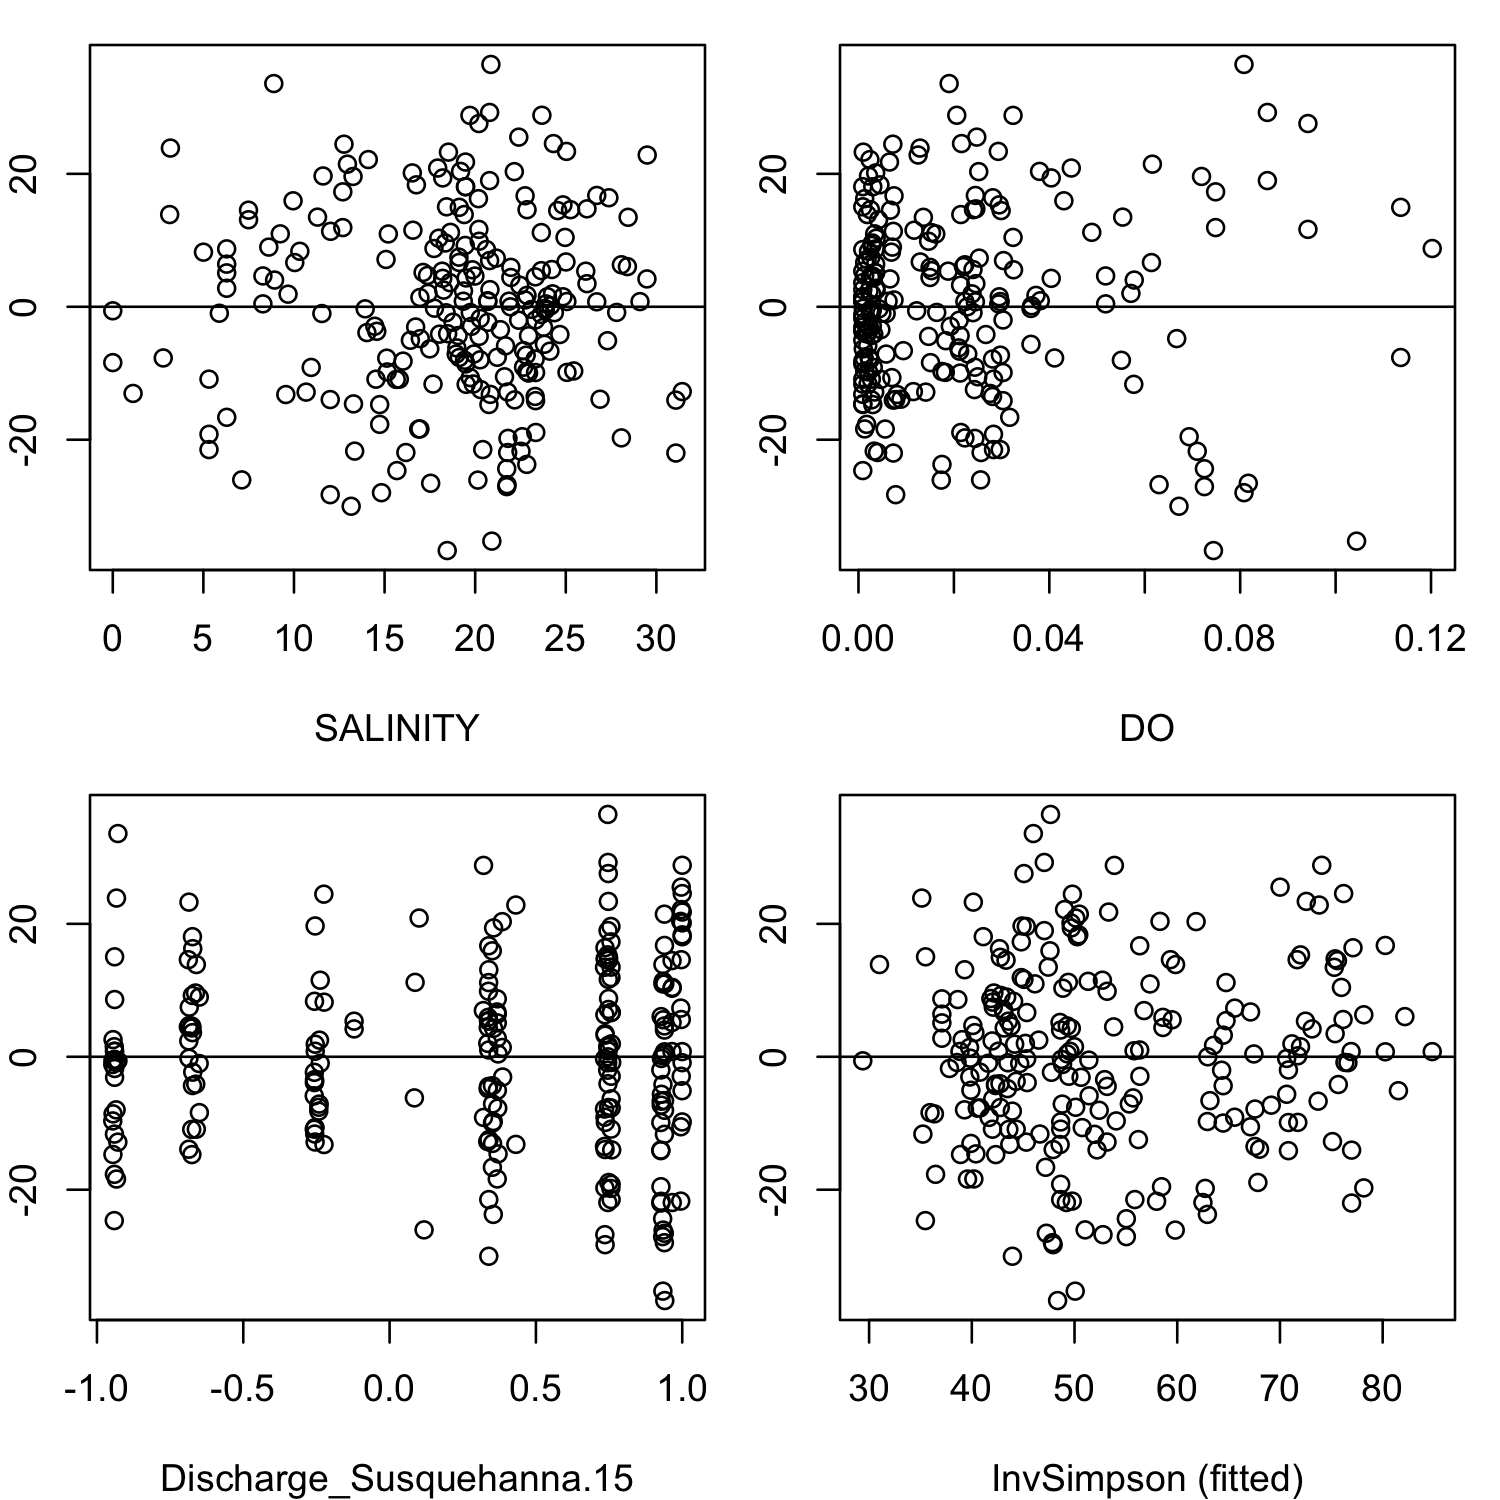

In [294]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 250)
par(mfrow = c(2, 2), mar=c(4,2,1,1), cex=0.9)
eE2 <- resid(envM2)
plot(y = eE2, x = obs_df$SALINITY, xlab = "SALINITY", ylab = "Residuals")
abline(0,0)
plot(eE2 ~ obs_df$PO4F, xlab = "DO", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ obs_df$FallPeak, xlab = "Discharge_Susquehanna.15", ylab = "Residuals")
abline(0, 0)
plot(eE2 ~ Fit, xlab = "InvSimpson (fitted)", ylab = "Residuals")
abline(0, 0)

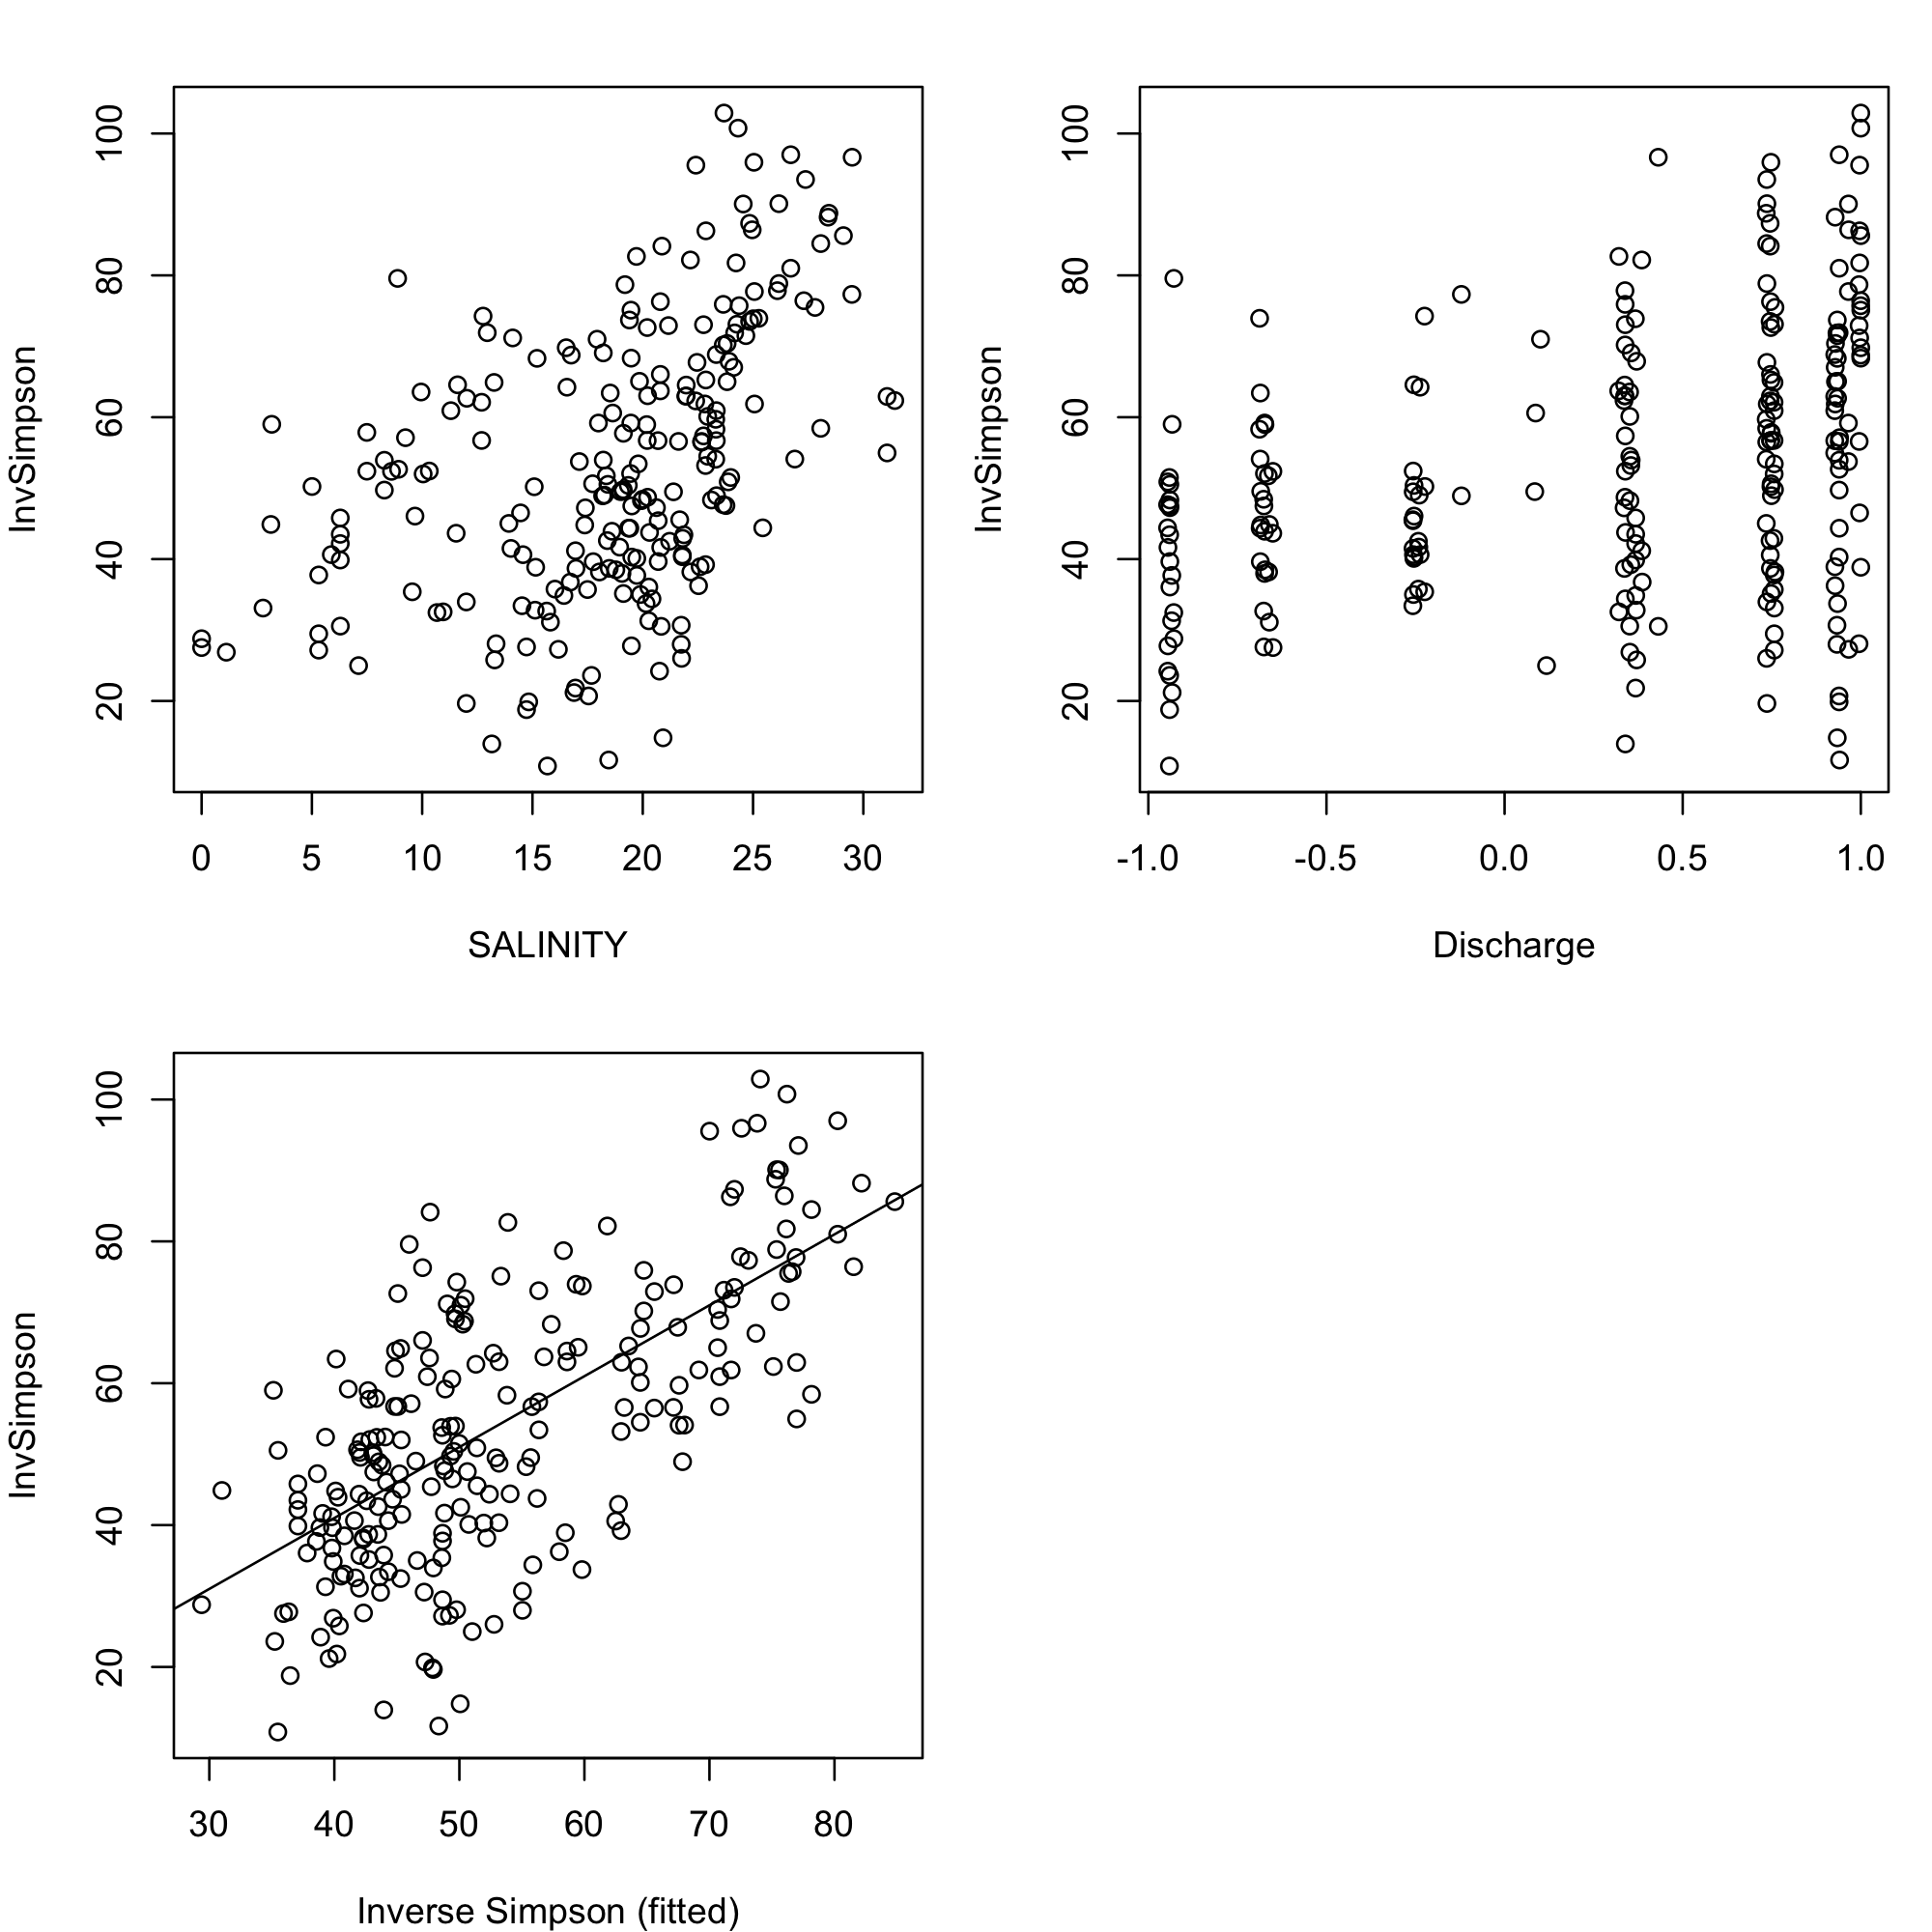

In [296]:
options(repr.plot.width=8, repr.plot.height=8, repr.plot.res = 250)
par(mfrow = c(2, 2), mar=c(4,4,2,1), cex=0.9)
plot(y = obs_df$InvSimpson, x = obs_df$SALINITY, xlab = "SALINITY", ylab = "InvSimpson")
abline(0,0)
plot(obs_df$InvSimpson ~ obs_df$FallPeak, xlab = "Discharge", ylab = "InvSimpson")
plot(obs_df$InvSimpson ~ Fit, xlab = "Inverse Simpson (fitted)", ylab = "InvSimpson")
abline(1, 1)
par(op)

In [315]:
library(ggplot2)
library(lubridate)

selected_predictors1 = c('PO4F', 'FallPeak', 'cruise_id', 'SampleDate', 'SALINITY')
selected_predictors2 = c('StatName')
selected_response = c('InvSimpson')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], 
                          all_alpha[,selected_response])[rownames(predict(envM2)),]

colnames(obs_df) <- c(selected_predictors1, selected_predictors2, selected_response)

obs_df[,'MonthYear'] <- paste(month(as.POSIXlt(obs_df$SampleDate)), "/", 
                              substring(year(as.POSIXlt(obs_df$SampleDate)), 3), sep="")

obs_df[,'MonthYear'] <- factor(obs_df[,'MonthYear'], 
                               levels=c('7/16', '8/16', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17'))

colnames(obs_df)[colnames(obs_df) == 'FallPeak'] = 'Seasonality'
colnames(obs_df)[colnames(obs_df) == 'SALINITY'] = 'Salinity'
obs_df$PO4F = obs_df$PO4F*1000
colnames(obs_df)[colnames(obs_df) == 'PO4F'] = 'Phosphate'
colnames(obs_df)[colnames(obs_df) == 'StatName'] = 'Station.Group'
colnames(obs_df)[colnames(obs_df) == 'cruise_id'] = 'Cruise.ID'
colnames(obs_df)[colnames(obs_df) == 'InvSimpson'] = 'Inverse.Simpson'

obs_df$Cruise.ID <- factor(obs_df$Cruise.ID)

obs_df[,'Data.Type'] = 'Measured'
mod_df = obs_df
mod_df[,'Data.Type'] = 'Modeled'
mod_df[,'Inverse.Simpson'] <- predict(envM2)

obsmod_df = rbind.data.frame(obs_df, mod_df)
obsmod_df$Data.Type <- as.character(obsmod_df$Data.Type)
obADF = obsmod_df$Seasonality
colSums(is.na(obsmod_df))

Phosphate     Seasonality       Cruise.ID      SampleDate        Salinity 
              0               0               0               0               0 
  Station.Group Inverse.Simpson       MonthYear       Data.Type 
              0               0               0               0

[1] -1.00 -0.75 -0.50 -0.25  0.00  0.25  0.50  0.75  1.00  1.25

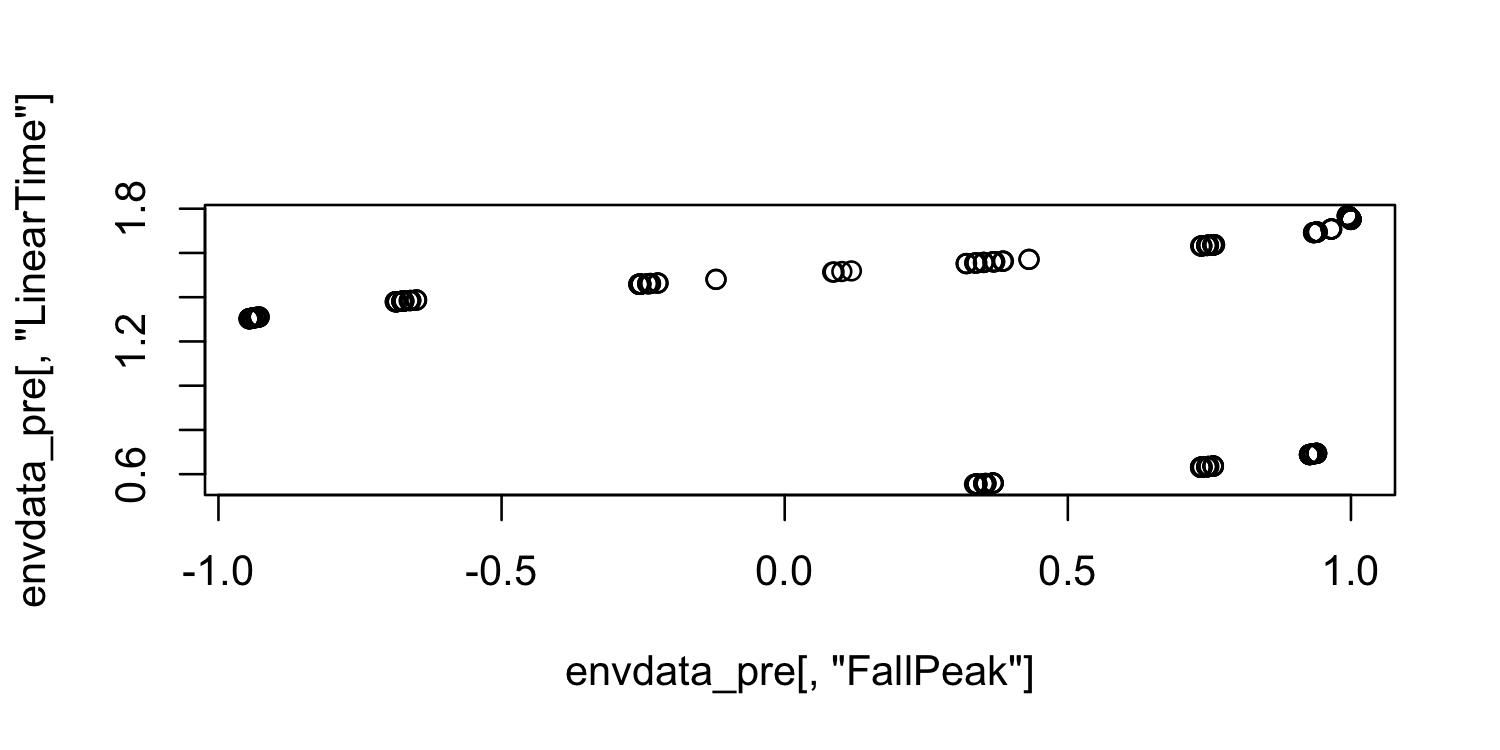

In [316]:
options(repr.plot.width=6, repr.plot.height=3, repr.plot.res = 250)
plot(envdata_pre[,'FallPeak'], envdata_pre[,'LinearTime'])
seq(-1, 1.25, .25)
abline(v=)

In [317]:
obADF = obsmod_df$Seasonality
obsmod_df[, 'ADFFactor'] = cut(obADF, breaks=c(-1,-0.5,  0, .25, 0.5, 0.85, 1.25), 
                                     include.lowest = T, right = F)
table(obsmod_df[, 'ADFFactor'])
obsmod_df$Seasonality = obsmod_df$ADFFactor

obsmod_df[, 'TPFactor'] = cut(obsmod_df$Phosphate, include.lowest = T, right = F,
                              breaks=c(0, quantile(obsmod_df$Phosphate, seq(1/6, 5/6, 1/6)), 
                                       max(obsmod_df$Phosphate)*1.1))
table(obsmod_df$TPFactor)
obsmod_df$Phosphate = obsmod_df$TPFactor

obsmod_df[, 'SALFactor'] = cut(obsmod_df$Salinity, include.lowest = T, right = F,
                              breaks=c(0, quantile(obsmod_df$Salinity, seq(1/6, 5/6, 1/6)), max(obsmod_df$Salinity)*1.1))
obsmod_df$Salinity = obsmod_df$SALFactor
table(obsmod_df$SALFactor)
colSums(is.na(obsmod_df))



  [-1,-0.5)    [-0.5,0)    [0,0.25)  [0.25,0.5)  [0.5,0.85) [0.85,1.25] 
         98          48           8          88         104         120 


   [0,1.98)  [1.98,3.6)  [3.6,14.7) [14.7,24.4) [24.4,37.6)  [37.6,132] 
         78          68          86          76          80          78 


   [0,12.7) [12.7,17.5) [17.5,19.7) [19.7,21.8) [21.8,23.8) [23.8,34.6] 
         76          78          78          78          78          78 

Phosphate     Seasonality       Cruise.ID      SampleDate        Salinity 
              0               0               0               0               0 
  Station.Group Inverse.Simpson       MonthYear       Data.Type       ADFFactor 
              0               0               0               0               0 
       TPFactor       SALFactor 
              0               0

Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”


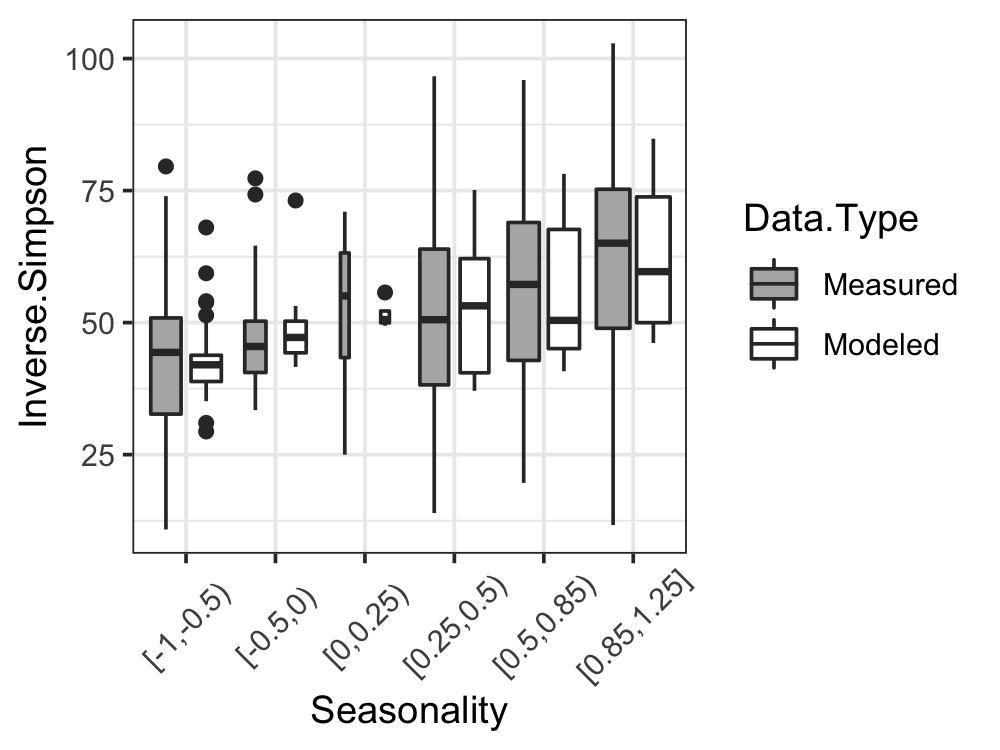

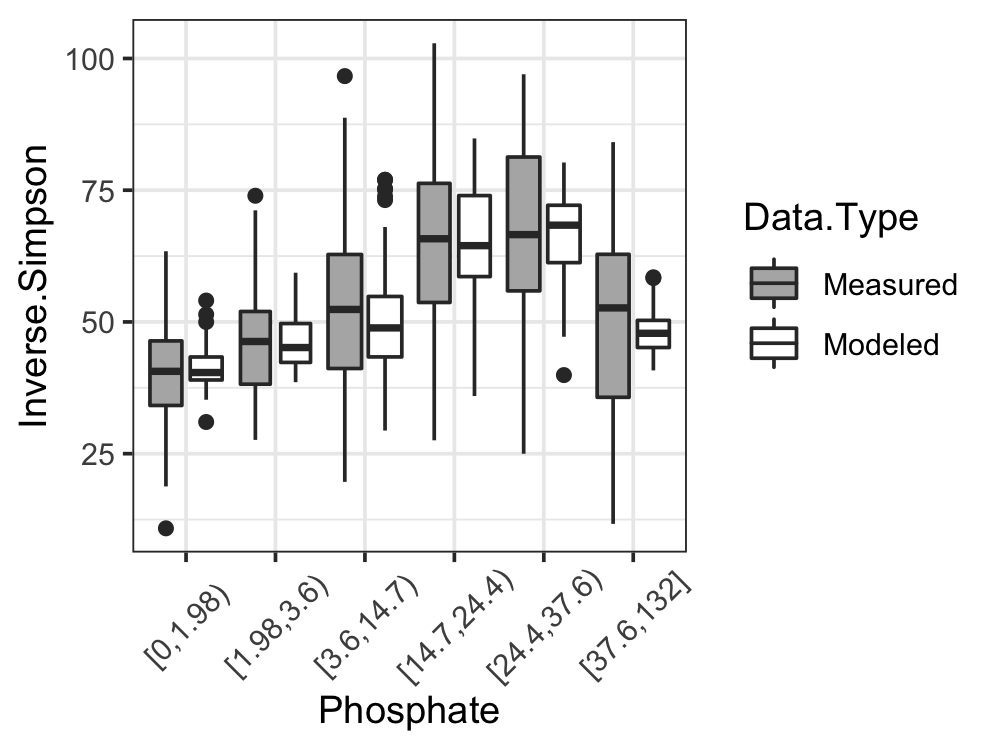

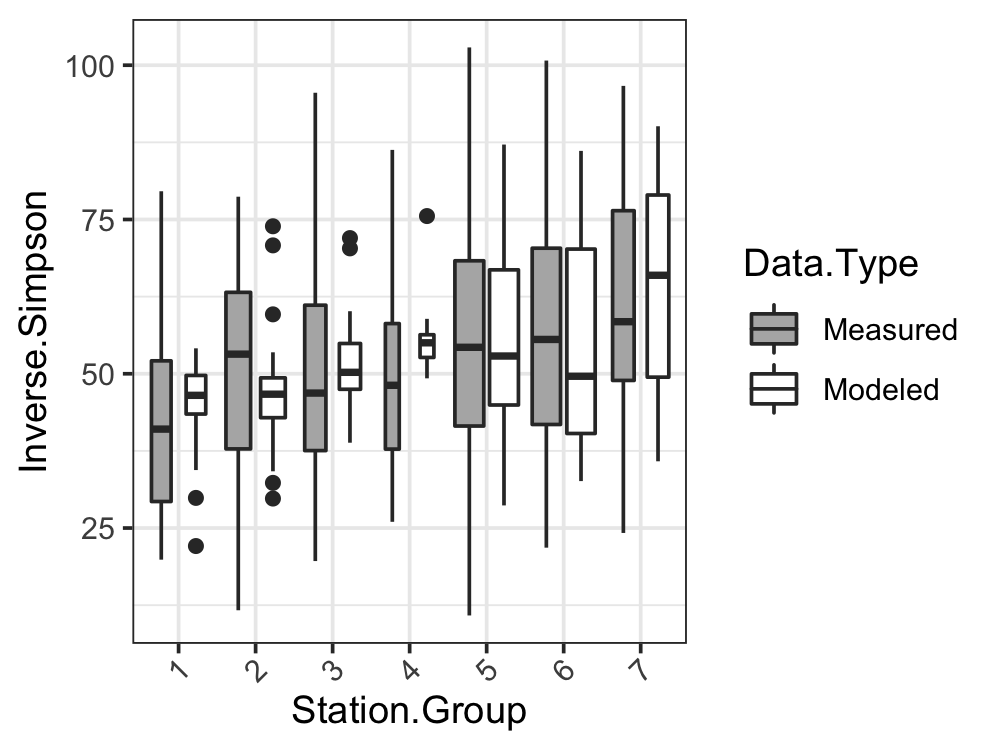

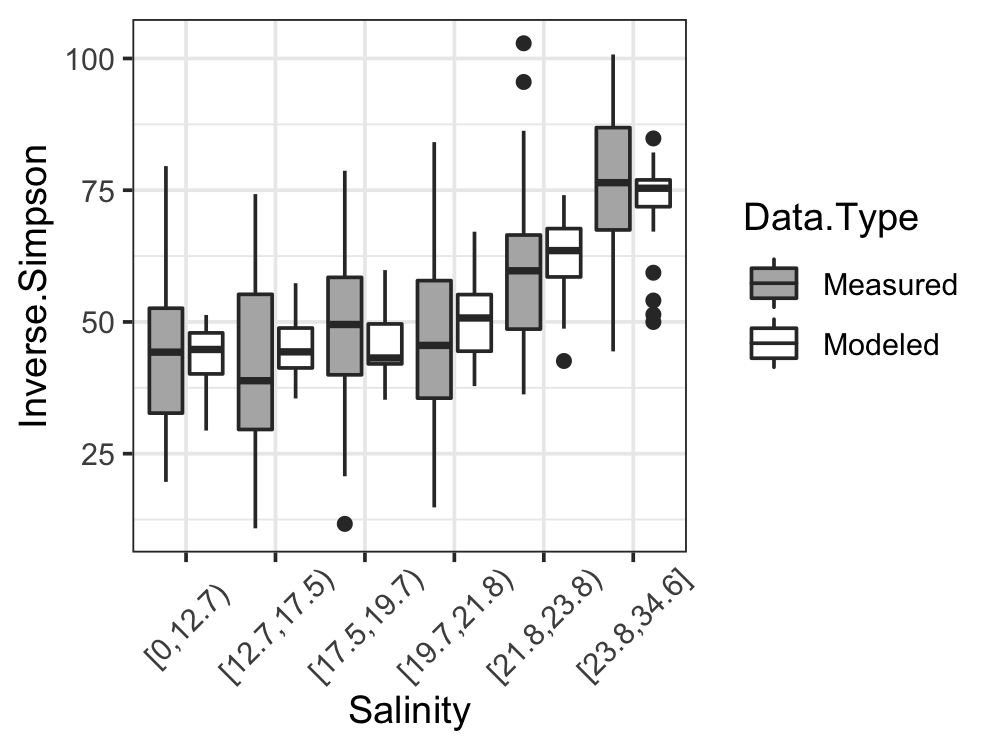

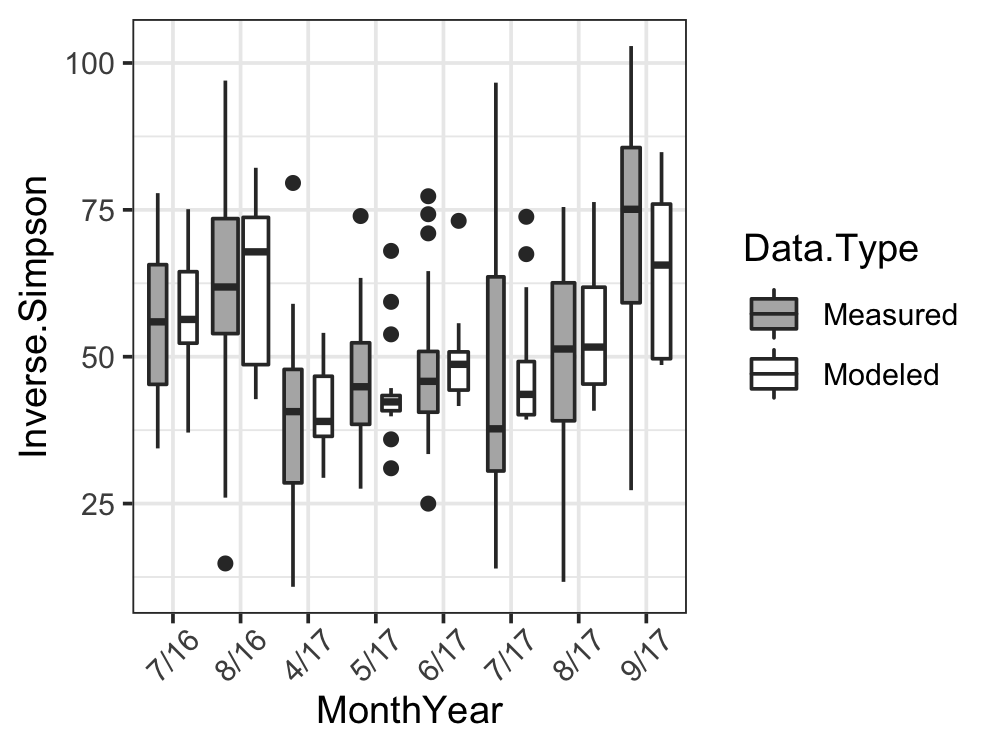

In [318]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 250)

bp <- ggplot(obsmod_df, aes(x=Seasonality, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) ##+ coord_cartesian(ylim=c(0, 150))

bp4 <- ggplot(obsmod_df, aes(x=Phosphate, y=Inverse.Simpson, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) ##+ coord_cartesian(ylim=c(0, 150))

bp5 <- ggplot(obsmod_df, aes(x=Salinity, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) #+ coord_cartesian(ylim=c(0, 150))

bp6 <- ggplot(obsmod_df, aes(x=MonthYear, y=Inverse.Simpson, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) #+ coord_cartesian(ylim=c(0, 150))

bp
bp4
bp2
bp5
bp6

In [326]:
colnames(pred_resp_f)
pred_resp_fpd <- cbind(pred_resp_f)
pred_resp_fpd$Microbial.Clusters <- NULL

upper_model = lm(FaithsPD ~ ., data=pred_resp_fpd)
lower_model = lm(FaithsPD ~ 1, data=pred_resp_fpd)
n = length(resid(lower_model))

fbstep_fpd = stepAIC(lower_model, scope=formula(upper_model), 
                         scale = 0, direction = 'both', trace=1, k=log(n))
length(colnames(fbstep_fpd$model))
extractAIC(fbstep_fpd)
colnames(fbstep_fpd$model)

[1] "PHEO"                     "TN"                      
 [3] "TP"                       "CHLA"                    
 [5] "DOP"                      "DON"                     
 [7] "NH4F"                     "NO2F"                    
 [9] "NO3F"                     "PC"                      
[11] "PO4F"                     "DO"                      
[13] "PH"                       "SALINITY"                
[15] "WTEMP"                    "Latitude"                
[17] "WIND_RATIO_BWI.15"        "WIND_RATIO_BWI.30"       
[19] "WIND_RATIO_BWI.60"        "PRECIP24HR_BWI.15"       
[21] "PRECIP24HR_BWI.30"        "PRECIP24HR_BWI.60"       
[23] "measurement_PAR.15"       "measurement_PAR.30"      
[25] "measurement_PAR.60"       "WaterColumnPosition"     
[27] "cruise_id"                "LinearTime"              
[29] "DayLength"                "FallPeak"                
[31] "Discharge_Susquehanna.15" "Discharge_Sum.15"        
[33] "Microbial.Clusters"       "Habitat"                 
[35] "StatName"                 "FaithsPD"

Start:  AIC=3223.94
FaithsPD ~ 1

                           Df Sum of Sq       RSS    AIC
+ FallPeak                  1  78026627 119513995 3110.8
+ Discharge_Sum.15          1  73882891 123657731 3118.9
+ Discharge_Susquehanna.15  1  71722634 125817988 3122.9
+ PO4F                      1  67462493 130078129 3130.8
+ DO                        1  62676482 134864140 3139.3
+ cruise_id                10  87961566 109579056 3139.5
+ measurement_PAR.60        1  57762862 139777760 3147.8
+ WTEMP                     1  48219846 149320776 3163.4
+ CHLA                      1  46075277 151465345 3166.7
+ PC                        1  44476888 153063734 3169.2
+ measurement_PAR.30        1  43283437 154257185 3171.0
+ PRECIP24HR_BWI.60         1  40787998 156752624 3174.8
+ Habitat                   2  42637388 154903234 3177.5
+ SALINITY                  1  36258705 161281917 3181.5
+ DOP                       1  32831926 164708696 3186.5
+ TP                        1  32665202 164875420 3186


Step:  AIC=3027.75
FaithsPD ~ FallPeak + PC + DO + SALINITY

                           Df Sum of Sq       RSS    AIC
+ measurement_PAR.15        1   4910772  73505111 3017.9
- PC                        1    330412  78746296 3023.3
+ LinearTime                1   2900199  75515685 3024.3
+ measurement_PAR.60        1   2731252  75684631 3024.8
<none>                                   78415883 3027.8
+ PH                        1   1779708  76636175 3027.8
+ PRECIP24HR_BWI.30         1   1618855  76797028 3028.3
+ WIND_RATIO_BWI.15         1   1541152  76874732 3028.5
+ measurement_PAR.30        1   1477073  76938811 3028.7
+ WIND_RATIO_BWI.30         1   1178027  77237856 3029.7
+ WIND_RATIO_BWI.60         1    957967  77457916 3030.3
+ PRECIP24HR_BWI.60         1    951191  77464692 3030.3
+ Latitude                  1    897881  77518003 3030.5
+ WTEMP                     1    676464  77739420 3031.2
+ PRECIP24HR_BWI.15         1    591036  77824847 3031.4
+ NO3F                    

[1] 6

[1]    6.00 2990.54

[1] "FaithsPD"           "FallPeak"           "DO"                
[4] "SALINITY"           "measurement_PAR.15" "PH"

In [327]:
addedvars = c('FaithsPD', 'FallPeak', 'SALINITY', 'PO4F')
remaining_vars  = colnames(pred_resp_fpd)[which(!(colnames(pred_resp_fpd) %in% addedvars))]
factors_ = remaining_vars[which(sapply(pred_resp_fpd[,remaining_vars], class) == 'factor')]
string_start = "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6)"
x = formula(string_start)
fA2 <- gam(x, data = pred_resp_fpd)
score_start = BIC(fA2)
addone = c()
for (rv in remaining_vars){
    if (rv %in% factors_){
        mod_string = paste(string_start, ' + ', rv)
    } else {
        mod_string = paste(string_start, '+ s(', rv, ", bs='cs', k=6)")
    }
    print(mod_string)
    fmod <- gam(formula(mod_string), data = pred_resp_fpd)
    score_diff = score_start - BIC(fmod)
    addone = c(addone, score_diff)
}
names(addone) <- remaining_vars
base::sort(addone, decreasing=T)[1:5]

[1] "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( PHEO , bs='cs', k=6)"
[1] "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( TN , bs='cs', k=6)"
[1] "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( TP , bs='cs', k=6)"
[1] "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( CHLA , bs='cs', k=6)"
[1] "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( DOP , bs='cs', k=6)"
[1] "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( DON , bs='cs', k=6)"
[1] "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( NH4F , bs='cs', k=6)"
[1] "FaithsPD ~ 1  + s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s( NO2F , bs='cs', k=6)

measurement_PAR.60  WIND_RATIO_BWI.15 measurement_PAR.30              WTEMP 
         10.013870           4.358155           4.266610           3.462579 
              PHEO 
          3.447772

[1] 3681.77

[1] 0.6606358

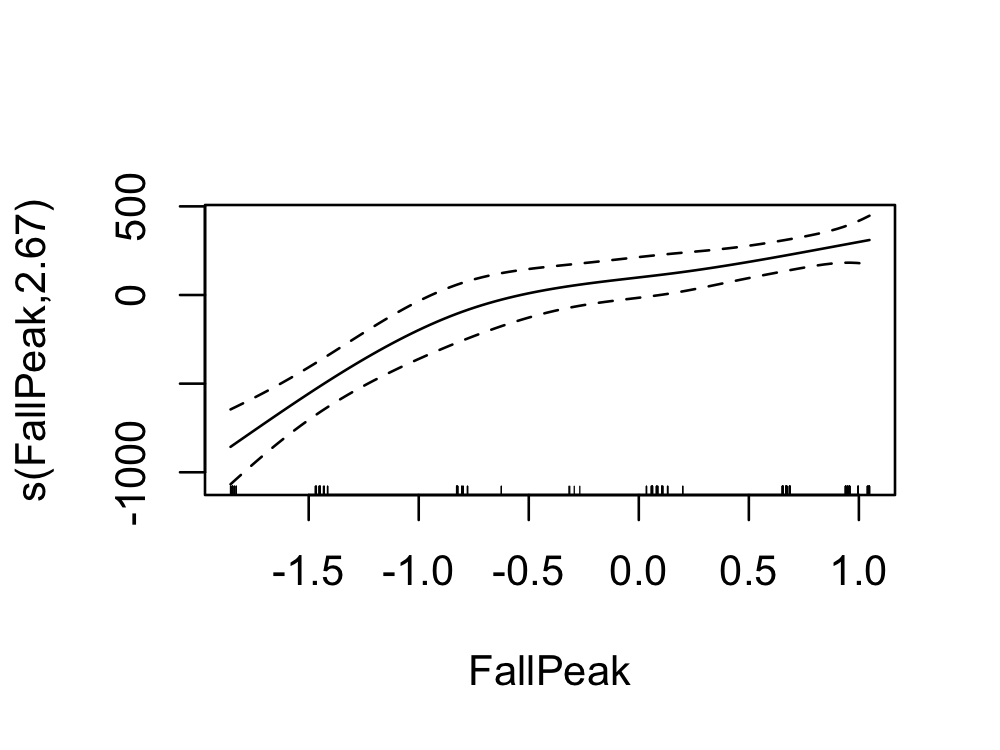

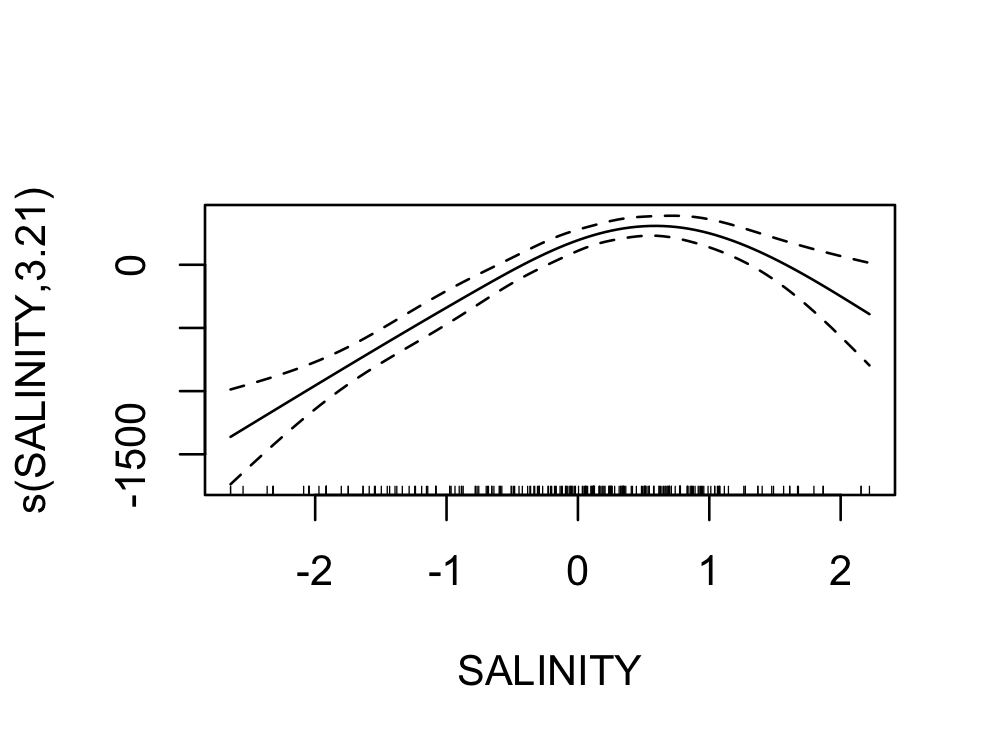

In [328]:
fmod <- gam(FaithsPD ~ s(FallPeak, bs='cs', k=5) +  + s(SALINITY, bs='cs', k=6) + 
            PO4F, data = pred_resp_fpd)
BIC(fmod)
postResample(obs=pred_resp_fpd$FaithsPD, pred=predict(fmod))[['Rsquared']]
plot(fmod, scale=0)

In [330]:
vf4 <- varIdent(form =~ StatName)
vf5 <- varIdent(form =~ WaterColumnPosition)
vf6 <- varExp(form =~ SALINITY)
vf7 <- varIdent(form =~ cruise_id)

fA2 <- gam(FaithsPD ~ s(FallPeak, bs='cs', k=6) + s(SALINITY, bs='cs', k=6) + 
           s(PO4F, bs='cs', k=6), data = pred_resp_fpd)

fAM2 <- gamm(FaithsPD ~ s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6),
                        data = pred_resp_fpd, weights = vf4)

fAM3 <- gamm(FaithsPD ~ s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s(SALINITY, bs='cs', k=6),
                        data = pred_resp_fpd, weights = vf5)

fAM4 <- gamm(FaithsPD ~ s(FallPeak, bs='cs', k=6) + s(PO4F, bs='cs', k=6) + s(SALINITY, bs='cs', k=6),
                        data = pred_resp_fpd, weights=vf7)

postResample(pred=predict(fA2), obs=pred_resp_fpd$FaithsPD)
postResample(pred=predict(fAM2$gam), obs=pred_resp_fpd$FaithsPD)
postResample(pred=predict(fAM3$gam), obs=pred_resp_fpd$FaithsPD)
postResample(pred=predict(fAM4$gam), obs=pred_resp_fpd$FaithsPD)

summary(fA2)
AIC(fA2)
summary(fAM4$gam)
AIC(fAM4$lme)
anova(fA2)
coef(fA2)

RMSE    Rsquared         MAE 
519.1488289   0.6782522 407.0497075

RMSE    Rsquared         MAE 
671.5176923   0.4614544 528.2300215

RMSE    Rsquared         MAE 
529.9320150   0.6647078 413.1798495

RMSE    Rsquared         MAE 
529.9320150   0.6647078 413.1798495


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(FallPeak, bs = "cs", k = 6) + s(SALINITY, bs = "cs", 
    k = 6) + s(PO4F, bs = "cs", k = 6)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2874.74      34.57   83.15   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df      F  p-value    
s(FallPeak) 4.906      5 17.731 6.72e-16 ***
s(SALINITY) 3.189      5 27.064  < 2e-16 ***
s(PO4F)     1.431      5  9.381 2.37e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.664   Deviance explained = 67.8%
GCV = 2.9527e+05  Scale est. = 2.821e+05  n = 236

[1] 3643.826


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(FallPeak, bs = "cs", k = 6) + s(PO4F, bs = "cs", 
    k = 6) + s(SALINITY, bs = "cs", k = 6)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2874.74      35.16   81.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
              edf Ref.df      F  p-value    
s(FallPeak) 2.618      5 13.836 2.40e-15 ***
s(PO4F)     1.901      5  8.552 6.58e-11 ***
s(SALINITY) 3.378      5 26.536  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.653   
  Scale est. = 2.9055e+05  n = 236

[1] 3674.259


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(FallPeak, bs = "cs", k = 6) + s(SALINITY, bs = "cs", 
    k = 6) + s(PO4F, bs = "cs", k = 6)

Approximate significance of smooth terms:
              edf Ref.df      F  p-value
s(FallPeak) 4.906  5.000 17.731 6.72e-16
s(SALINITY) 3.189  5.000 27.064  < 2e-16
s(PO4F)     1.431  5.000  9.381 2.37e-12

(Intercept) s(FallPeak).1 s(FallPeak).2 s(FallPeak).3 s(FallPeak).4 
   2874.73662     200.98941     431.33927     634.45028     408.95531 
s(FallPeak).5 s(SALINITY).1 s(SALINITY).2 s(SALINITY).3 s(SALINITY).4 
    679.53759     485.71974     472.93433     678.30398    1104.52862 
s(SALINITY).5     s(PO4F).1     s(PO4F).2     s(PO4F).3     s(PO4F).4 
   -269.98518      41.02946     187.53628     322.04281     479.43414 
    s(PO4F).5 
    647.42345

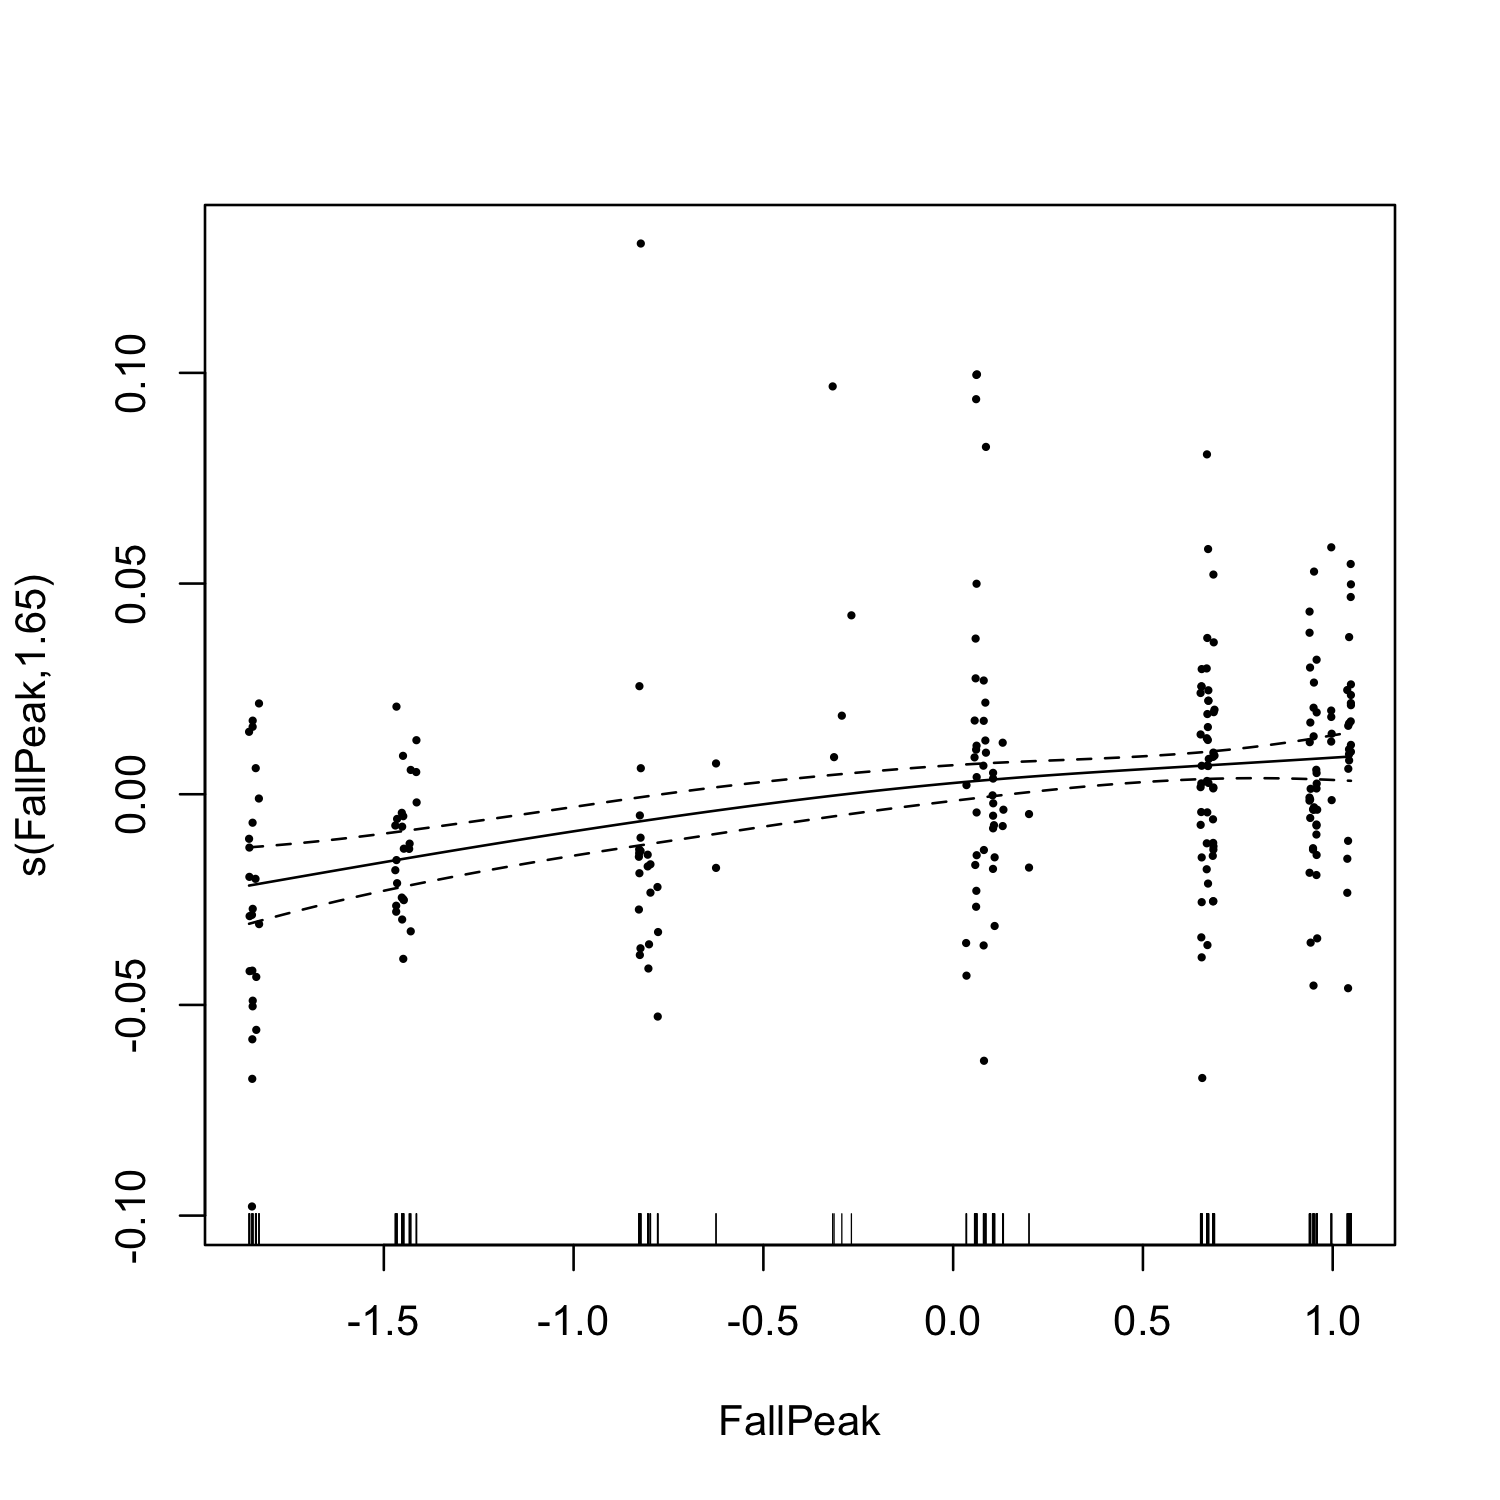

In [23]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 250)
#op <- par(mfrow = c(2, 2))
plot(fA2, residuals=TRUE, pch=19, cex=.3, scale=0)


	Anderson-Darling normality test

data:  fE2
A = 1.9104, p-value = 6.914e-05


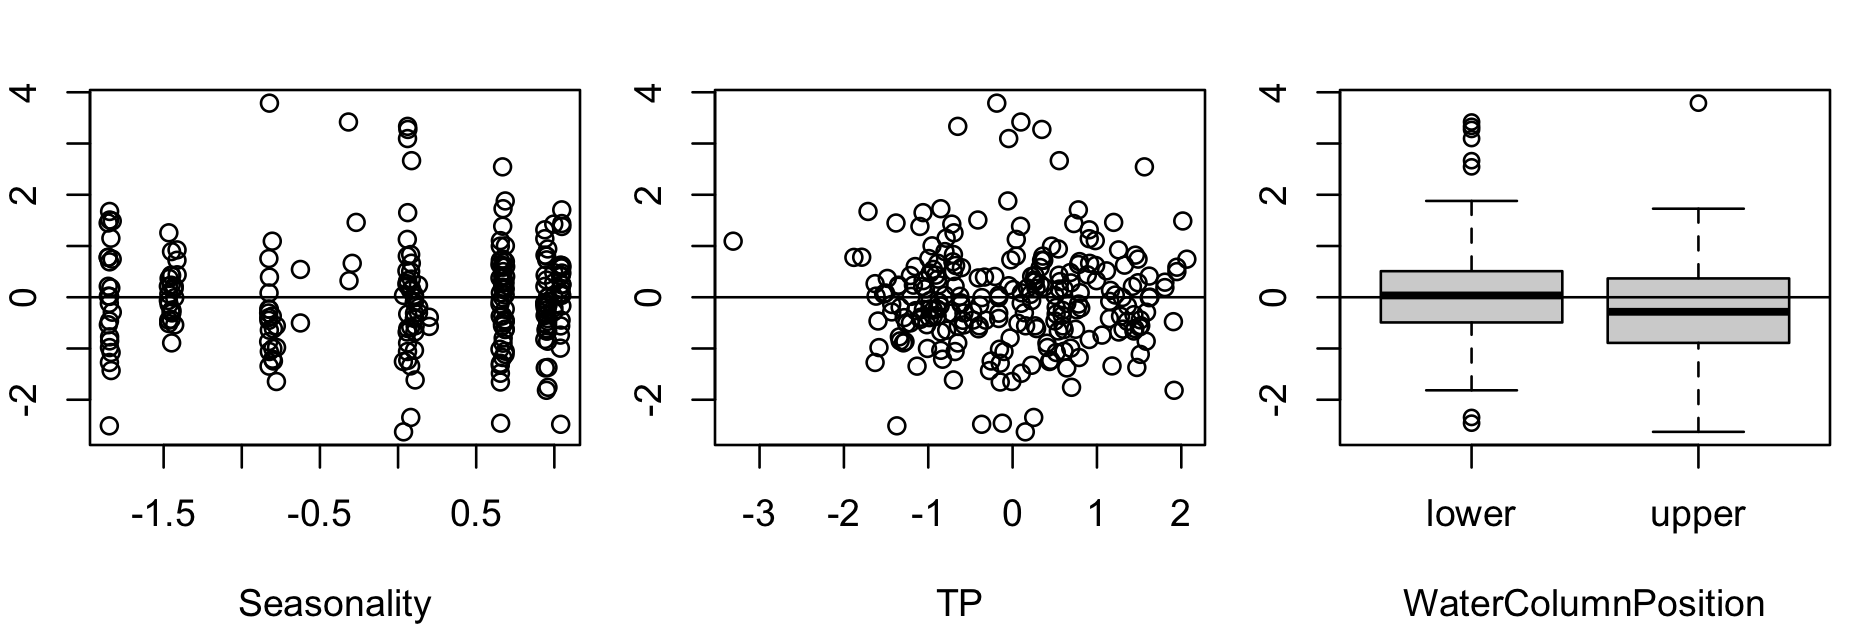

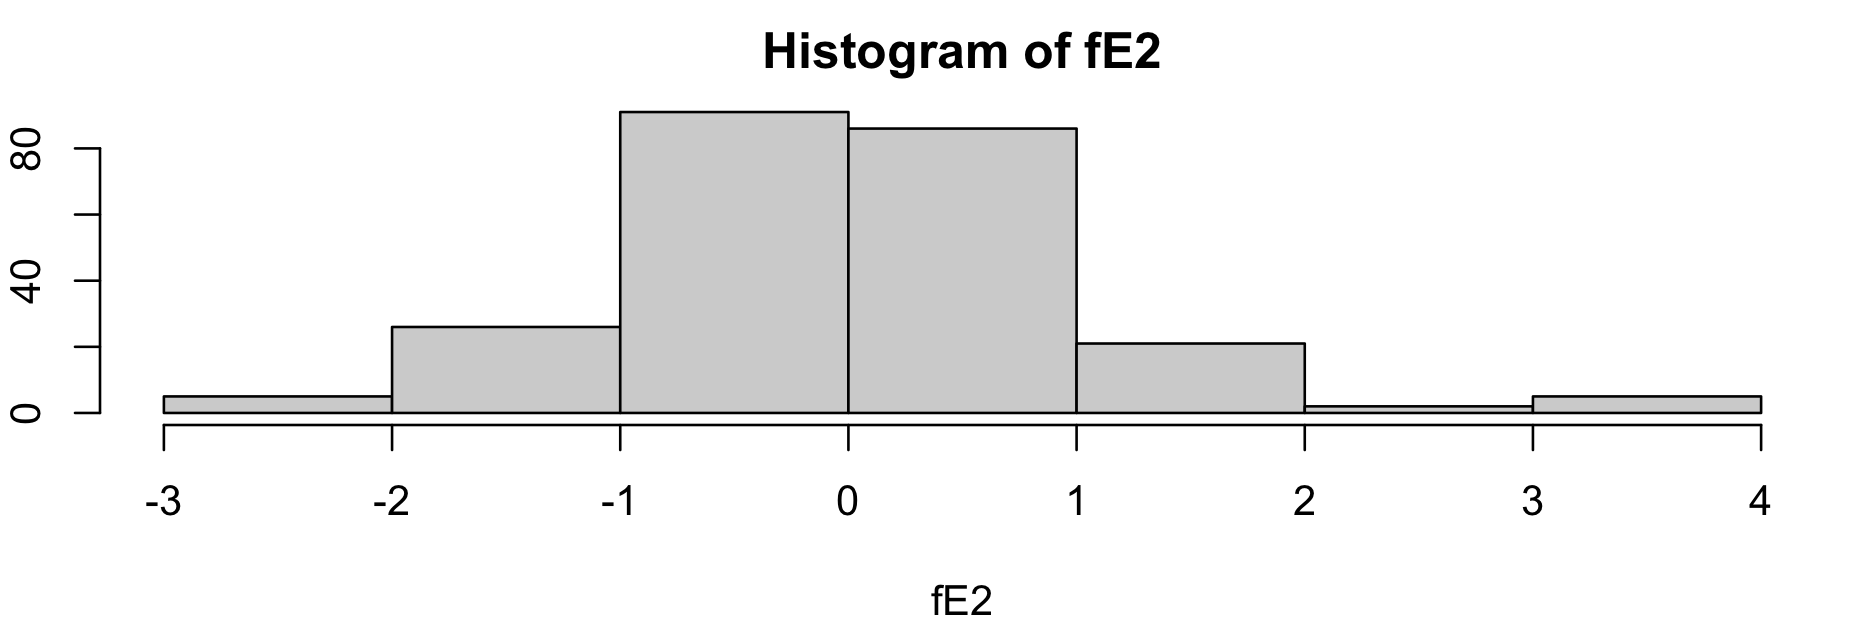

In [24]:
options(repr.plot.width=7.5, repr.plot.height=2.5)
par(mfrow = c(1, 3), mar=c(4,2,2,1), cex=0.9)
fE2 <- scale(resid(fM3))
Fit.fA2 <- fitted(fM3)
ad.test(fE2)
plot(y = fE2, x = pred_resp_f[,'FallPeak'], xlab = "Seasonality", ylab = "Residuals")
abline(0,0)
plot(fE2 ~ pred_resp_f[,'TP'], xlab = "TP", ylab = "Residuals")
abline(0, 0)
boxplot(fE2 ~ pred_resp_f[,'WaterColumnPosition'], xlab = "WaterColumnPosition", ylab = "Residuals")
abline(0, 0)
par(op)

hist(fE2)


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 8 iterations.
The RMS GCV score gradient at convergence was 0.8439291 .
The Hessian was positive definite.
Model rank =  16 / 16 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

              k'  edf k-index p-value  
s(FallPeak) 5.00 4.91    0.95   0.205  
s(SALINITY) 5.00 3.19    0.90   0.075 .
s(PO4F)     5.00 1.43    0.98   0.385  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


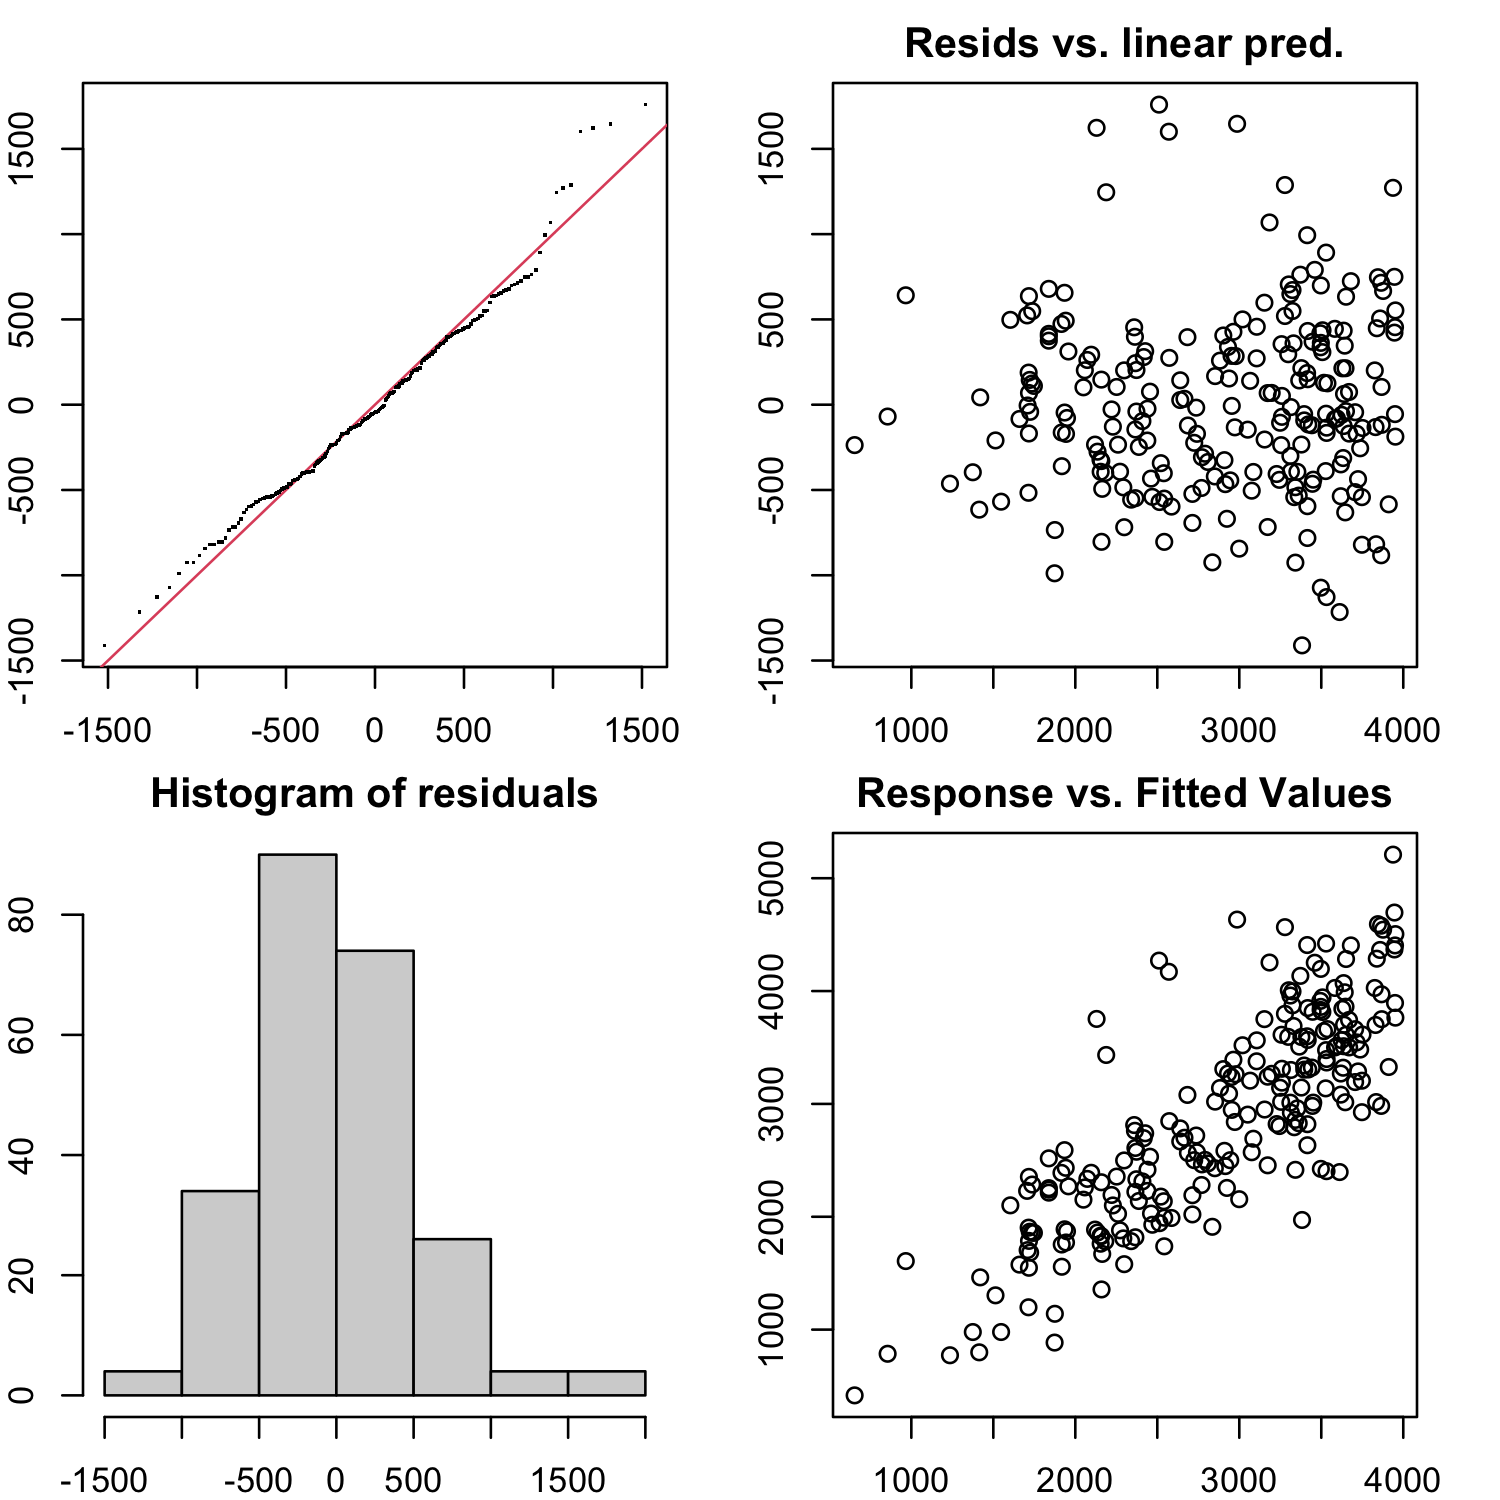

In [331]:
options(repr.plot.width=6, repr.plot.height=6)
par(mar = c(2, 2, 2, 2))
gam.check(fA2)


Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(Phosphate, bs = "cs", k = 6) + s(Seasonality, bs = "cs", 
    k = 6) + s(Salinity, bs = "cs", k = 6)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  54.8477     0.3172   172.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df      F  p-value    
s(Phosphate)   3.628      5  7.682 4.98e-08 ***
s(Seasonality) 4.846      5 22.890  < 2e-16 ***
s(Salinity)    3.697      5 30.541  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.691   Deviance explained = 70.7%
GCV = 24.844  Scale est. = 23.44     n = 233

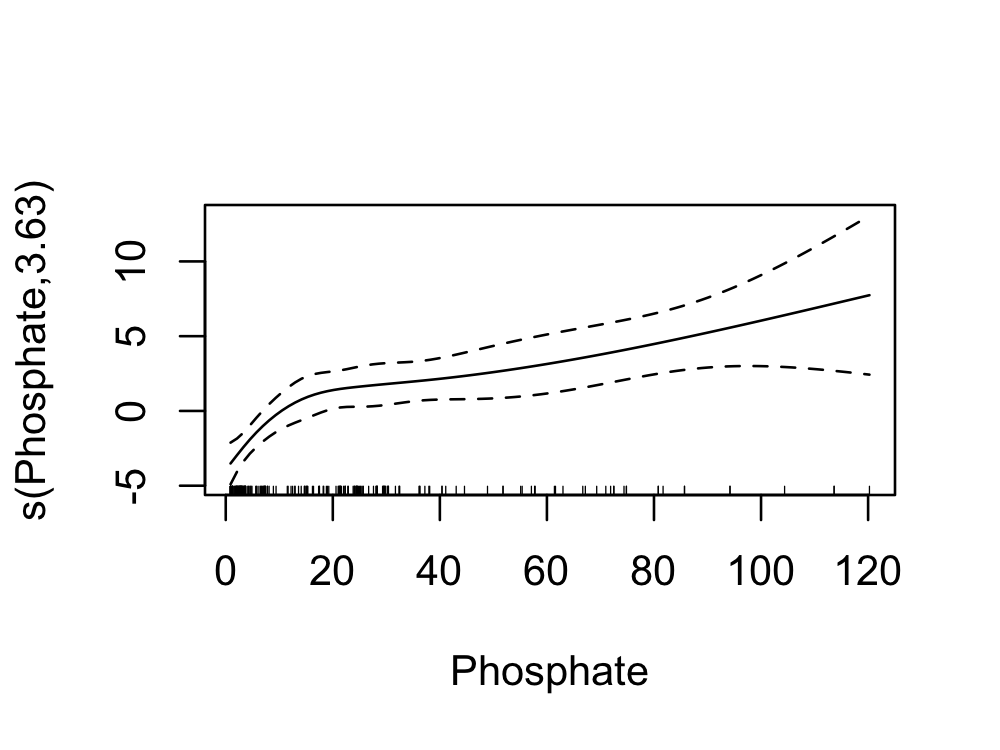

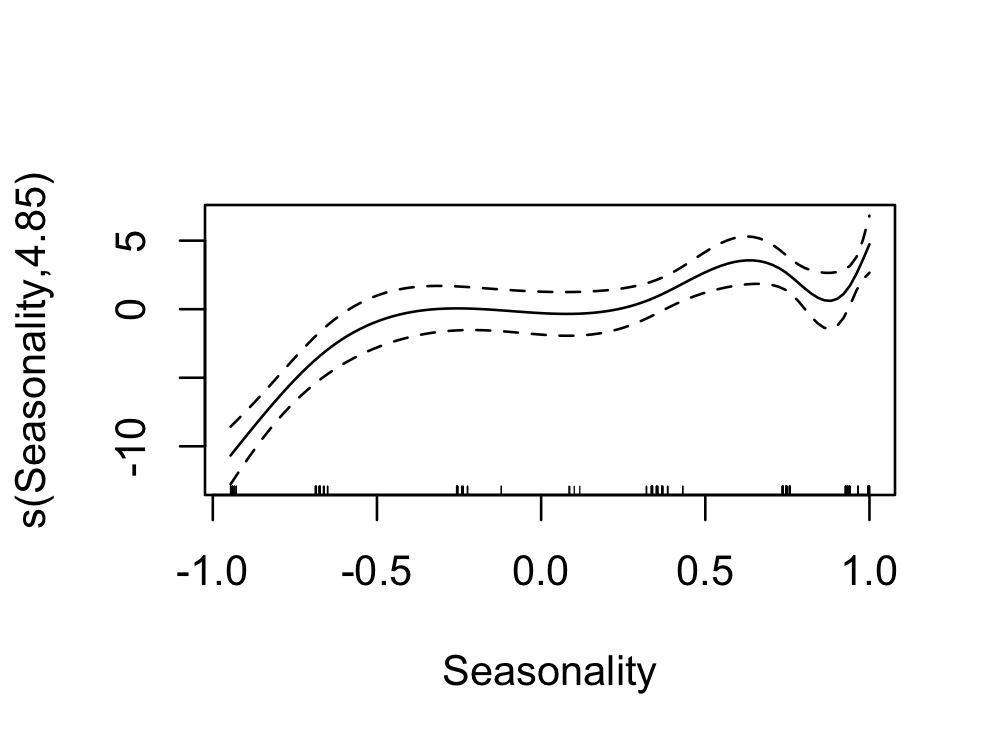

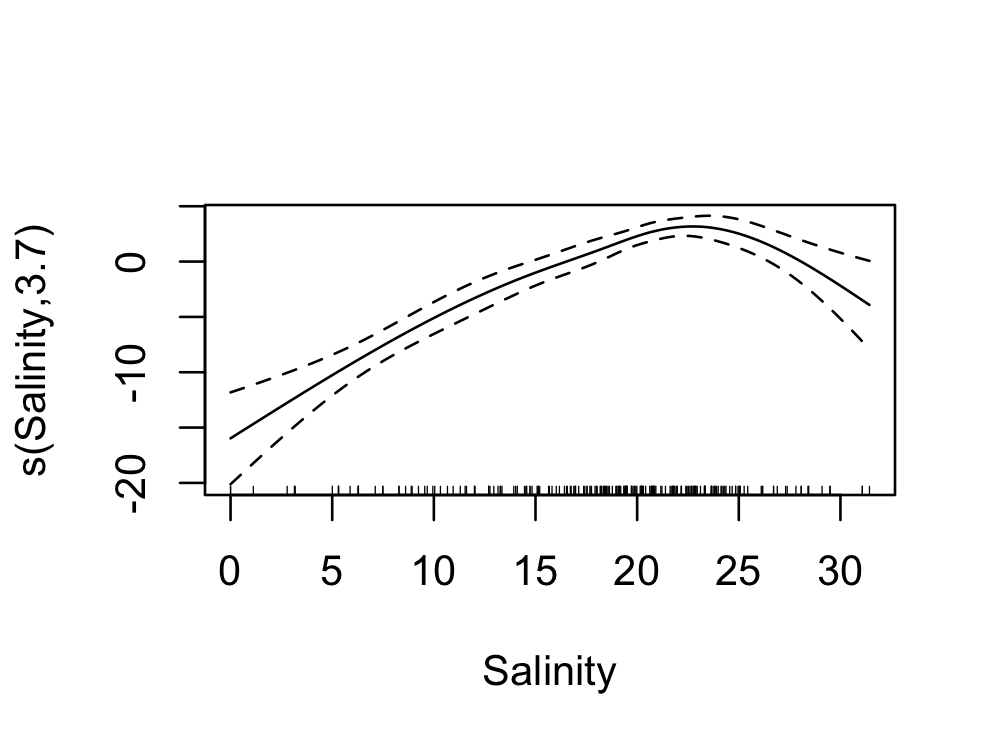

In [342]:
library(lubridate)
selected_predictors1 = c('SampleDate', 'cruise_id', 'PO4F', 'FallPeak', 'SALINITY')
selected_predictors2 = c('StatName')
selected_response = c('FaithsPD')
obs_df = cbind.data.frame(envdata_pre[,selected_predictors1], envdata[,selected_predictors2], 
                          all_alpha[,selected_response])
obs_df = obs_df[complete.cases(obs_df),]
colnames(obs_df) <- c(selected_predictors1, selected_predictors2, selected_response)

obs_df[,'MonthYear'] <- paste(month(as.POSIXlt(obs_df$SampleDate)), "/", substring(year(as.POSIXlt(obs_df$SampleDate)), 3), sep="")
obs_df[,'MonthYear'] <- factor(obs_df[,'MonthYear'], 
                               levels=c('7/16', '8/16', '4/17', '5/17', '6/17', '7/17', '8/17', '9/17'))
obs_df[,'Month'] <- factor(month(as.POSIXlt(obs_df$SampleDate)))
colnames(obs_df)[colnames(obs_df) == 'cruise_id'] = 'Cruise.ID'
obs_df$Cruise.ID <- factor(obs_df$Cruise.ID)
obs_df$PO4F = obs_df$PO4F*1000
colnames(obs_df)[colnames(obs_df) == 'PO4F'] = 'Phosphate'
colnames(obs_df)[colnames(obs_df) == 'FallPeak'] = 'Seasonality'
colnames(obs_df)[colnames(obs_df) == 'StatName'] = 'Station.Group'
colnames(obs_df)[colnames(obs_df) == 'SALINITY'] = 'Salinity'

obs_df[which(obs_df$Surface.Bottom == 'upper'), 'Surface.Bottom'] = 'Surface'
obs_df[which(obs_df$Surface.Bottom == 'lower'), 'Surface.Bottom'] = 'Bottom'

obs_df$Surface.Bottom = factor(obs_df$Surface.Bottom, levels=c('Surface', 'Bottom'))

obs_df[,'Data.Type'] = 'Measured'
mod_df = obs_df
mod_df[,'Data.Type'] = 'Modeled'
fM3 <- gam(FaithsPD ~ s(Phosphate, bs='cs', k=6) +  s(Seasonality, bs='cs', k=6) + 
                      s(Salinity, bs='cs', k=6), data = obs_df)
summary(fM3)
plot(fM3, scale=0)


In [360]:
attributes(summary(fM3))
print(summary(fM3)$s.pv)
summary(fM3)

$names
 [1] "p.coeff"       "se"            "p.t"           "p.pv"         
 [5] "residual.df"   "m"             "chi.sq"        "s.pv"         
 [9] "scale"         "r.sq"          "family"        "formula"      
[13] "n"             "dev.expl"      "edf"           "dispersion"   
[17] "pTerms.pv"     "pTerms.chi.sq" "pTerms.df"     "cov.unscaled" 
[21] "cov.scaled"    "p.table"       "pTerms.table"  "s.table"      
[25] "method"        "sp.criterion"  "rank"          "np"           

$class
[1] "summary.gam"

[1] 4.979912e-08 2.261882e-20 2.500332e-30



Family: gaussian 
Link function: identity 

Formula:
FaithsPD ~ s(Phosphate, bs = "cs", k = 6) + s(Seasonality, bs = "cs", 
    k = 6) + s(Salinity, bs = "cs", k = 6)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  54.8477     0.3172   172.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df      F  p-value    
s(Phosphate)   3.628      5  7.682 4.98e-08 ***
s(Seasonality) 4.846      5 22.890  < 2e-16 ***
s(Salinity)    3.697      5 30.541  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.691   Deviance explained = 70.7%
GCV = 24.844  Scale est. = 23.44     n = 233

In [343]:
mod_df[,'FaithsPD'] <- predict(fM3)[rownames(obs_df)]
obsmod_df = rbind.data.frame(obs_df, mod_df)
obsmod_df$Data.Type <- as.character(obsmod_df$Data.Type)

obADF = obsmod_df$Seasonality
obsmod_df[, 'ADFFactor'] = cut(obADF, breaks=c(-1,-0.5,  0, .25, 0.5, 0.85, 1.25), 
                                     include.lowest = T, right = F)
table(obsmod_df[, 'ADFFactor'])
obsmod_df$Seasonality = obsmod_df$ADFFactor

obsmod_df[, 'PFactor'] <-NA
obsmod_df[, 'PFactor'] = cut(obsmod_df$Phosphate, breaks=c(0, quantile(obsmod_df$Phosphate, seq(1/6, 5/6, 1/6)), 
                                               max(obsmod_df$Phosphate)*1.1), include.lowest = T, right = F)
obsmod_df$Phosphate = obsmod_df$PFactor
table(obsmod_df$PFactor)

obsmod_df[, 'SALFactor'] <-NA
obsmod_df[, 'SALFactor'] = cut(obsmod_df$Salinity, breaks=c(0, quantile(obsmod_df$Salinity, seq(1/6, 5/6, 1/6)), 
                                               max(obsmod_df$Salinity)*1.1), include.lowest = T, right = F)
obsmod_df$Salinity = obsmod_df$SALFactor
table(obsmod_df$SALFactor)

colSums(is.na(obsmod_df))


  [-1,-0.5)    [-0.5,0)    [0,0.25)  [0.25,0.5)  [0.5,0.85) [0.85,1.25] 
         98          48           8          88         104         120 


   [0,1.98)  [1.98,3.6)  [3.6,14.7) [14.7,24.4) [24.4,37.6)  [37.6,132] 
         78          68          86          76          80          78 


   [0,12.7) [12.7,17.5) [17.5,19.7) [19.7,21.8) [21.8,23.8) [23.8,34.6] 
         76          78          78          78          78          78 

SampleDate      Cruise.ID      Phosphate    Seasonality       Salinity 
             0              0              0              0              0 
 Station.Group       FaithsPD      MonthYear          Month Surface.Bottom 
             0              0              0              0            466 
     Data.Type      ADFFactor        PFactor      SALFactor 
             0              0              0              0

Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”
Warning message:
“Can't preserve total widths when varwidth = TRUE.”


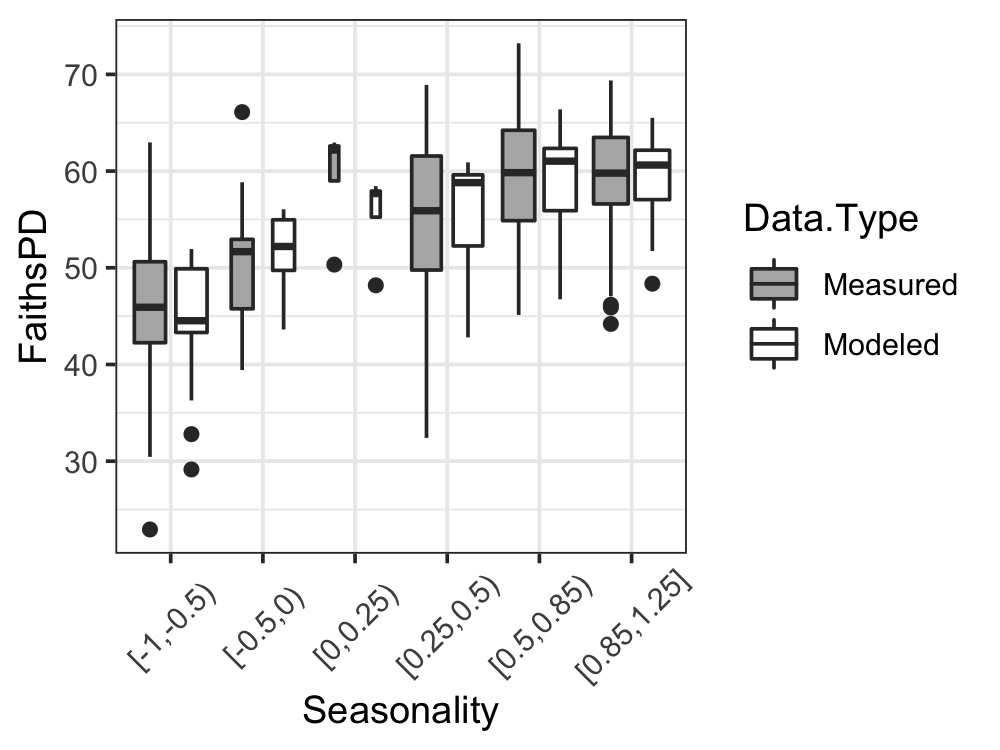

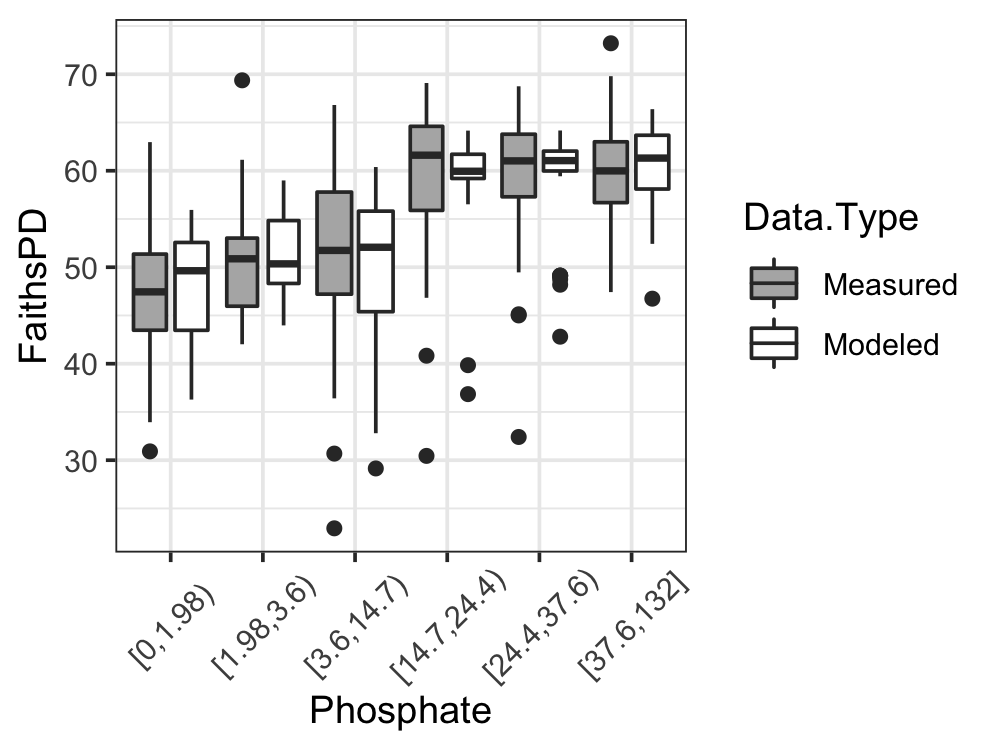

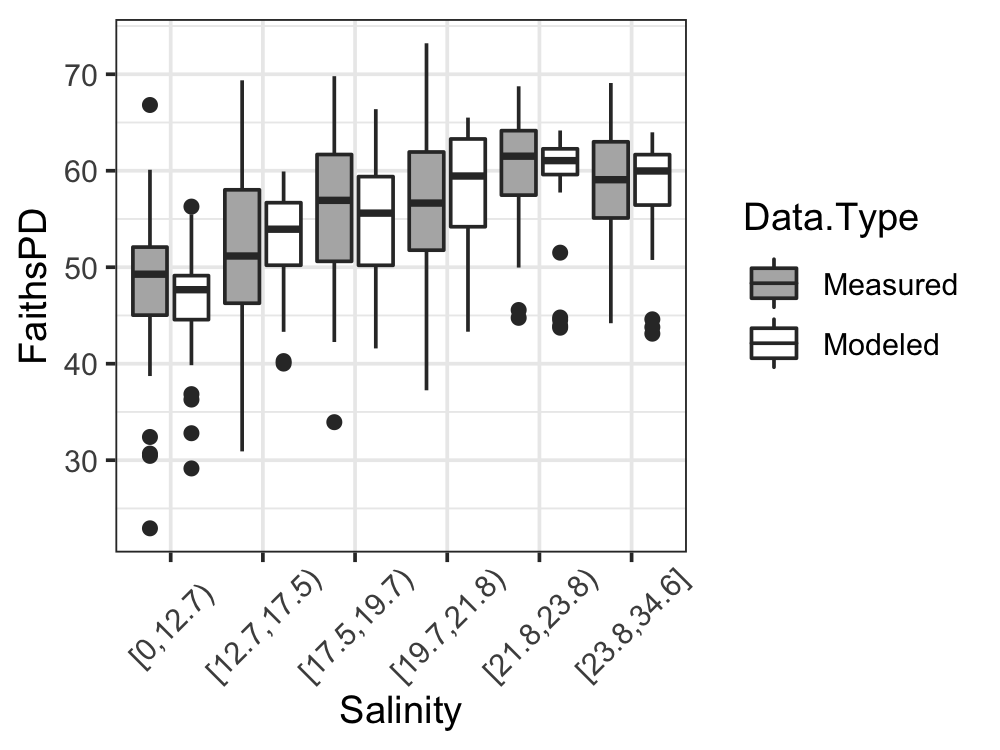

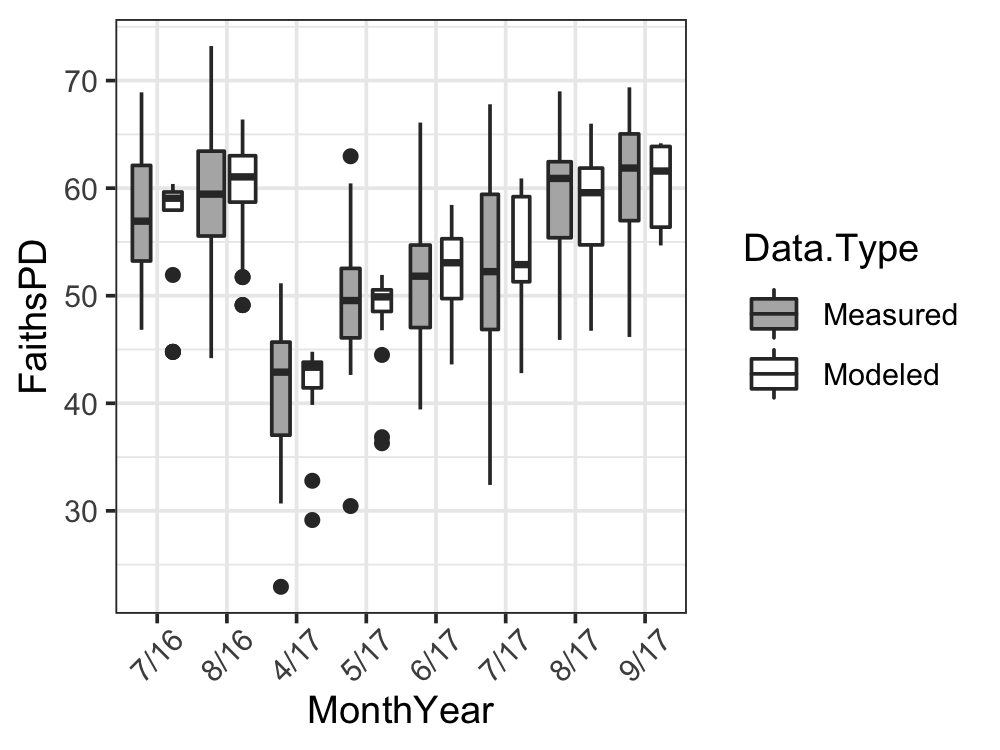

In [345]:
options(repr.plot.width=4, repr.plot.height=3, repr.plot.res = 250)

bp <- ggplot(obsmod_df, aes(x=Seasonality, y=FaithsPD, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) ##+ coord_cartesian(ylim=c(0, 150))

bp4 <- ggplot(obsmod_df, aes(x=Phosphate, y=FaithsPD, fill=Data.Type)) + 
       geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
       theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) ##+ coord_cartesian(ylim=c(0, 150))

bp5 <- ggplot(obsmod_df, aes(x=Salinity, y=FaithsPD, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) #+ coord_cartesian(ylim=c(0, 150))

bp6 <- ggplot(obsmod_df, aes(x=MonthYear, y=FaithsPD, fill=Data.Type)) + 
      geom_boxplot(position=position_dodge(0.9), varwidth=T) + scale_fill_grey(start=0.7, end=1.0) + 
      theme_bw() %+replace% theme(axis.text.x = element_text(angle = 45)) #+ coord_cartesian(ylim=c(0, 150))

bp
bp4
bp5
bp6

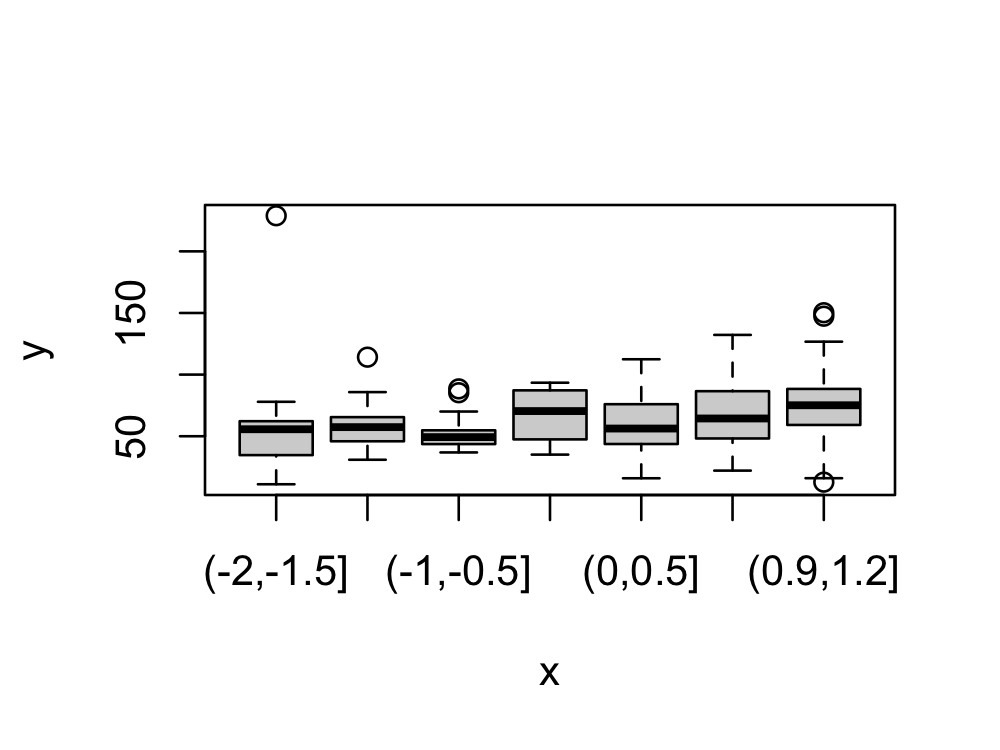

In [47]:
plot(cut(predictors_$FallPeak, c(-2., -1.5, -1, -0.5, 0, 0.5, .9, 1.2)), response_2)

In [ ]:

library(mgcv)
mixing_f = "/Volumes/KeithSSD/CB_V4/otu_data/mixing_data/2016_transect_mixing_data_products.txt"
mix_df = read.delim(mixing_f, row.names=2)
mix_df$X <- NULL
select_cols = c('faith_pd', 'WTEMP', 'Latitude', 'Depth', 'StatName', 'DO', 'PH',
                'SALINITY', 'anti_day_length', 'AC_PrinComp2', 'julian_day')

subfull = fulldata[rownames(mix_df), select_cols]
mixing_plus = cbind.data.frame(subfull, mix_df[,c(6:ncol(mix_df))])

# standardize the numeric columns
predictors_ns <- mixing_plus %>% mutate_if(is.numeric, list(~ as.numeric(scale(.))) )

corr <- data.frame(lapply(predictors_ns[,c('faith_pd', 'Latitude', 'DO','south_lim', 'WTEMP')], as.double))
# Plot the graph
#options(repr.plot.width=7, repr.plot.height=7)
#ggcorr(corr, method = c("pairwise", "spearman"), nbreaks = 6,
#       hjust = 0.92, size=4, label = TRUE, label_size = 2, color = "grey25")

pred_cols = c('WTEMP', 'Latitude', 'Depth', 'StatName', 'DO', 'PH', 'SALINITY', 
              'anti_day_length', 'AC_PrinComp2', 'julian_day', 'sum_horiz_dist', 'sum_vert_dist',
              'sum_downwelling', 'sum_upwelling', 'north_lim', 'south_lim', 'east_lim', 'west_lim',
              'up_lim', 'down_lim')
sum(pred_cols %in% colnames(mixing_plus))
length(pred_cols)
stepper = gam(faith_pd ~ s(Latitude, br='cs') + s(Depth, br='cs') + s(DO, br='cs') + s(PH, br='cs') + s(SALINITY, br='cs') + s(anti_day_length, br='cs') + s(AC_PrinComp2, br='cs') + s(julian_day, br='cs') + s(sum_horiz_dist, br='cs') + s(sum_vert_dist, br='cs') + s(sum_downwelling, br='cs') + s(sum_upwelling, br='cs') + s(north_lim, br='cs') + s(south_lim, br='cs') + s(east_lim, br='cs') + s(west_lim, br='cs') + s(up_lim, br='cs') + s(down_lim, br='cs'), data=mixing_plus)
#stepper
#fbstep_enspie = stepAIC(lower_model, scope=formula(upper_model), scale = 0, direction = 'forward', k=log(n), trace=0)
#length(colnames(fbstep_enspie$model))


fM2 <- gam(faith_pd ~ s(DO, bs = "cs") + s(south_lim, bs='cs') + s(WTEMP, bs='cs'), data = mixing_plus)


#anova(fM2)
#anova(fM2)
#summary(fM2)
#shapiro.test(resid(fM2))


In [ ]:
paste(colnames(mixing_plus), collapse="','")

In [ ]:
lmc <- lmeControl(niterEM = 5200, msMaxIter = 5200)

Mlm <- lm(Faiths.PD ~ Month*Year + Depth, data=faiths_df)
Mlme1 <- lme(Faiths.PD ~ 1 + Month + Depth, random = ~ 1 | Year, data=faiths_df, method="ML")
Mlme2 <- lme(Faiths.PD ~ 1 + Year + Depth, random = ~ 1 | Month, data=faiths_df, method="ML")

AIC(Mlme1, Mlme2, Mlm)
anova(Mlme1, Mlme2, Mlm)
summary(Mlme1)

In [ ]:
options(repr.plot.width=7, repr.plot.height=7)
E2 <- resid(Mlme1, type = "normalized")
F2 <- fitted(Mlme1)
op <- par(mfrow = c(2, 2), mar = c(4, 4, 3, 2))
MyYlab <- "Residuals"
plot(x = F2, y = E2, xlab = "Fitted values", ylab = MyYlab)
boxplot(E2 ~ faiths_df$Year, main = "Year", ylab = MyYlab)
plot(E2 ~ faiths_df$Depth, main = "Depth", ylab = MyYlab)
plot(x = month_year2, y = E2, ylab = MyYlab, main = "Month Year")
par(op)

In [ ]:



# cross validating smoothers is given by: 
# AM2 <- gam(ABUND  ̃ s(L.AREA, bs = "cs") + s(L.DIST, bs = "cs") + s(L.LDIST,bs = "cs") 
#                  + s(YR.ISOL, bs = "cs") + s(ALT, bs = "cs") + fGRAZE, data = Loyn)
# "edf" column in summary will show the relative amount of smoothing, if = 0, term is linear? 
# plots residuals against fitted values
# > plot(M1, which = c(1), col = 1, add.smooth = FALSE, caption = "")
# plot the residuals against each individual explanatory variable
# > plot(Squid$fMONTH, resid(M1), xlab = "Month", ylab = "Residuals")
# > plot(Squid$DML, resid(M1), xlab = "DML", ylab = "Residuals")
## This plots the residuals versus the two predictors in question, there is a facet for each factor level in month
# > E <- resid(M.lm)
# > coplot(E ∼ DML | fMONTH, data = Squid)


# (generalized least squares is a flavor of linear model with homogeneity corrections) 
# when the residuals deviate systematically with a variable, you can use a fixed variance structure:
# M.gls1 <- gls(Testisweight ∼ DML * fMONTH, weights = varFixed(∼DML), data = Squid)
# compare with: 
# M.lm <- gls(Testisweight ∼ DML * fMONTH, data=Squid)
# AIC(M.lm, M.gls1)
# if there is a variance structure that changes per a factor explanatory variable, we use:
# vf2 <- varIdent(form= ∼ 1 | fMONTH)
# as an alternative for the previous two, we can try:
# vf4 <- varPower(form =∼ DML | fMONTH) OR varExp(form =∼ DML | fMONTH) OR varConstPower(form =∼ DML | fMONTH)
# it is not clear if we can combine terms in varFixed or varIdent, but we can combine them seperately, e.g.
# vf8 <- varComb(varIdent(form =∼ 1 | fMONTH) , varExp(form =∼ DML) )
# varPower cannot be used if the covariate is ever equal to 0
## To confirm your choice, plot the error distribution versus predictors 
#E2 <- resid(M.gls4, type = "normalized") > coplot(E2 ∼ DML | fMONTH, data = Squid,
#ylab = "Normalised residuals")

#summary(continuous)
# plot a variable
#library(ggplot2)
#ggplot(continuous, aes(x = hours.per.week)) + geom_density(alpha = .2, fill = "#FF6666")
#ggplot(continuous, aes(x = educational.num)) + geom_density(alpha = .2, fill = "#32CD32")
#library(dplyr)

In [ ]:
set.seed(14)
create_train_test <- function(data, size = 0.8, train = TRUE) {
    n_row = nrow(data)
    total_row = size * n_row
    train_sample <- 1: total_row
    if (train == TRUE) {
        return (data[train_sample, ])
    } else {
        return (data[-train_sample, ])
    }
}
full_data = cbind(scale(response), predictors_ns)
colnames(full_data)[1] <- phenotype
row.names(full_data) <- row.names(mdata)
data_train <- create_train_test(full_data, 0.6, train = TRUE)
data_test <- create_train_test(full_data, 0.6, train = FALSE)
dim(data_train)
dim(data_test)
row.names(data_train)[1:5]

In [ ]:
head(data_train)

In [ ]:
library(scorer)
library(MASS)
library(caret)
library(leaps)
simple_model <- lm(faith_pd ~., data = data_train)
step_model <- stepAIC(simple_model, direction = "both", trace=FALSE)
ls(step_model)
summary(step_model)


In [ ]:
opt_model = lm(formula = faith_pd ~ Longitude + TrimCount + Year + julian_day + day_length + WTEMP + DO + PH + Depth_Percentage + Discharge_Susquehanna_14, data = data_train)
pred.w.clim <- predict(opt_model, data_test, interval = "confidence")
print(r2_score(data_test[,'faith_pd'], pred.w.clim[,'fit']))
pred.w.clim <- predict(simple_model, data_test, interval = "confidence")
print(r2_score(data_test[,'faith_pd'], pred.w.clim[,'fit']))



train.control <- trainControl(method="cv", number = 10)
step_model <- train(faith_pd ~., data = full_data, method = "leapSeq", trControl=train.control,
                    tuneGrid=data.frame(nvmax=1:15))

step_model$results
summary(step_model$finalModel)


In [ ]:
qqPlot(simple_model, simulate=T)
outlierTest(simple_model, labels=row.names(data_train))

In [ ]:
library(car)
pt_obj = powerTransform(continuous)
coef(p1, round=TRUE)
summary(m1 <- lm(bcPower(cycles, p1$roundlam) ~ len + amp + load, Wool))

#summary(p1 <- powerTransform(cycles ~ len + amp + load, Wool))
#ggplot(continuous, aes(x = hours.per.week)) + geom_density(alpha = .2, fill = "#FF6666")
#ggplot(data_adult_rescale, aes(x = educational.num)) + geom_density(alpha = .2, fill = "#32CD32")

In [ ]:
library(SoDA)
library(adespatial)
subm_geop <- mdata[,c("Longitude", "Latitude", "StationName")]
aggSub <- aggregate(.~ StationName, subm_geop, FUN=mean)

cart_coords = geoXY(latitude=aggSub$Latitude, longitude=aggSub$Longitude, unit=1000)
row.names(cart_coords) <- aggSub$StationName
stat_dists <- matrix(nrow=20, ncol=20)
for(i in 1:dim(stat_dists)[1]){
    for(j in 1:dim(stat_dists)[2]){
        stat_dists[i, j] <- geoDist(aggSub$Latitude[i], aggSub$Longitude[i], aggSub$Latitude[j], aggSub$Longitude[j])
    }
}
colnames(stat_dists) <- aggSub$StationName; row.names(stat_dists) <- aggSub$StationName;
cb.dbmem <- as.data.frame(dbmem(cart_coords, thresh = 45.0 ,silent = TRUE))
row.names(cb.dbmem) <- aggSub$StationName;
dim(mdata)
mdata[, colnames(cb.dbmem)] <- NA
for(cn in colnames(cb.dbmem)){
    for(stat_name in row.names(cb.dbmem)){
        mdata[mdata$StationName == stat_name , cn] <- cb.dbmem[stat_name, cn]
    }
}
head(mdata[c(66,77,99,111,155,200,225,250,300), colnames(cb.dbmem)])